In [1]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


Gaussian mixture

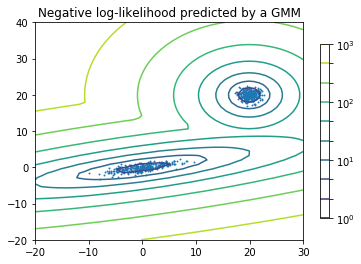

In [2]:
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample,two components
np.random.seed(0)

shifted_gaussian = np.random.randn(n_samples,2) + np.array([20,20])

C = np.array([[0,-0.7],[3.5,.7]])
stretched_gaussian = np.dot(np.random.randn(n_samples,2),C)

X_train = np.vstack([shifted_gaussian,stretched_gaussian])

# fit a gaussian mixture model with two components
clf = mixture.GaussianMixture(n_components=2,covariance_type='full')
clf.fit(X_train)

# display predicted scares by the model as a contour plot
x = np.linspace(-20,30.)
y = np.linspace(-20,40)
X,Y = np.meshgrid(x,y)
XX = np.array([X.ravel(),Y.ravel()]).T
Z = -clf.score_samples(XX).reshape(X.shape)

cs = plt.contour(X,Y,Z,norm=LogNorm(vmin=1.0,vmax=1000.),levels=np.logspace(0,3,10))
cb = plt.colorbar(cs,shrink=0.8,extend='both')
plt.scatter(X_train[:,0],X_train[:,1],.8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

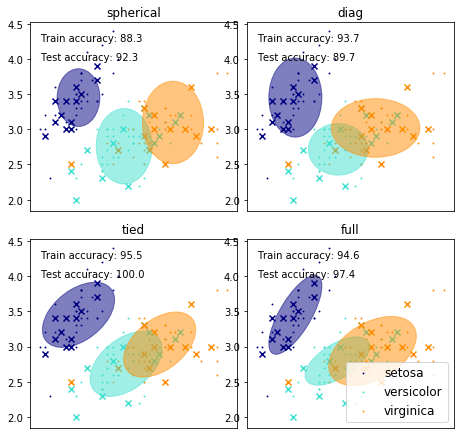

In [8]:
import matplotlib as mpl
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ['navy','turquoise','darkorange']

def make_ellipses(gmm,ax):
    for n,color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2,:2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2,:2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        
        v,w = np.linalg.eigh(covariances)
        u = w[0]/np.linalg.norm(w[0])
        angle = np.arctan2(u[1],u[0])
        angle = 180 * angle / np.pi
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n,:2],v[0],v[1],180 + angle,color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
iris = datasets.load_iris()

skf = StratifiedKFold(n_splits=4)
# only take the first fold
train_index,test_index = next(iter(skf.split(iris.data,iris.target)))
X_train,X_test = iris.data[train_index],iris.data[test_index]
y_train,y_test = iris.target[train_index],iris.target[test_index]

n_classes = len(np.unique(y_train))

# try  GMMs with different types of covariances
estimators = dict((cov_type,GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type,max_iter=20,random_state=0))
                 for cov_type in ['spherical','diag','tied','full'])
n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators //2 ,6))
plt.subplots_adjust(bottom=.01,top=0.95,hspace=.15,wspace=.05,left=.01,right=.99)

for index,(name,estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_train[y_train==i].mean(axis=0) 
                                    for i in range(n_classes)])
    estimator.fit(X_train)
    
    h = plt.subplot(2,n_estimators //2 ,index +1)
    make_ellipses(estimator,h)
    
    for n,color in enumerate(colors):
        data = iris.data[iris.target==n]
        plt.scatter(data[:,0],data[:,1],s=0.8,color=color,
                   label=iris.target_names[n])
    for n,color in enumerate(colors):
        data = X_test[y_test==n]
        plt.scatter(data[:,0],data[:,1],marker='x',color=color)
    
    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05,0.9,'Train accuracy: %.1f'% train_accuracy,
            transform=h.transAxes)
    
    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05,0.8,'Test accuracy: %.1f' % test_accuracy,
            transform=h.transAxes)
    plt.xticks(())
    plt.yticks()
    plt.title(name)
plt.legend(scatterpoints=1,loc='lower right',prop=dict(size=12))
plt.show()

    

        

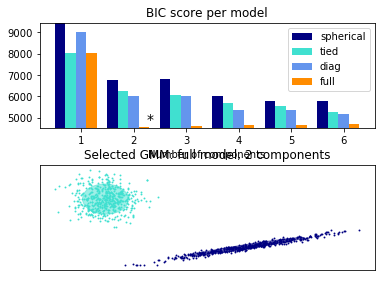

In [10]:
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture

n_samples = 500

# generate random samples,two components
np.random.seed(0)
C = np.array([[0.,-0.1],[1.7,.4]])
X = np.r_[np.dot(np.random.randn(n_samples,2),C),
         .7 * np.random.randn(n_samples,2)+ np.array([-6,3])]

lowest_bic = np.infty
bic = []
n_components_range = range(1,7)
cv_types = ['spherical','tied','diag','full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # fit a gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                     covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
bic = np.array(bic)
color_iter = itertools.cycle(['navy','turquoise','cornflowerblue','darkorange'])

clf = best_gmm
bars = []

# plot the bic scores
spl = plt.subplot(211)
for i,(cv_type,color) in enumerate(zip(cv_types,color_iter)):
    xpos = np.array(n_components_range) + .2 * (i -2)
    bars.append(plt.bar(xpos,bic[i * len(n_components_range):
                                (i+1) * len(n_components_range)],
               width=.2,color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(),bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()


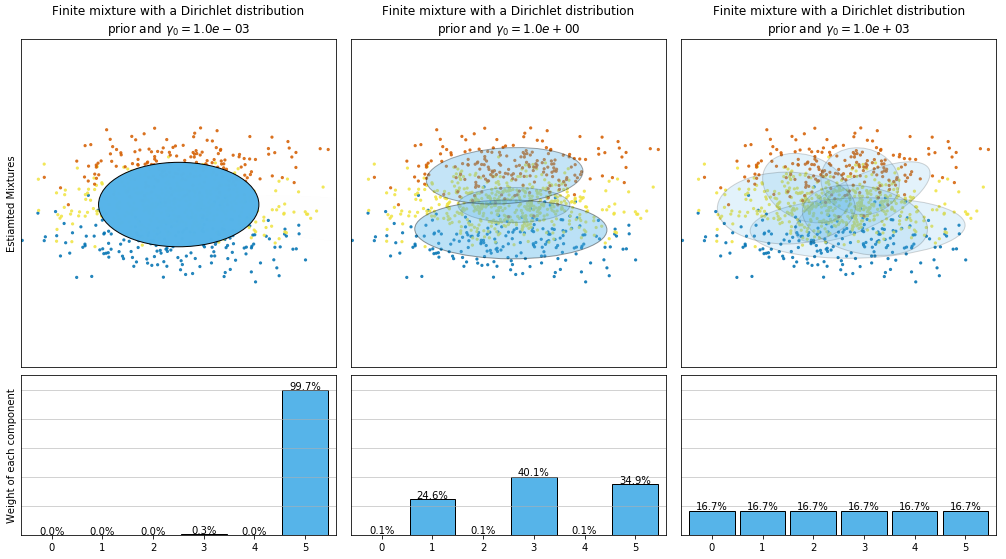

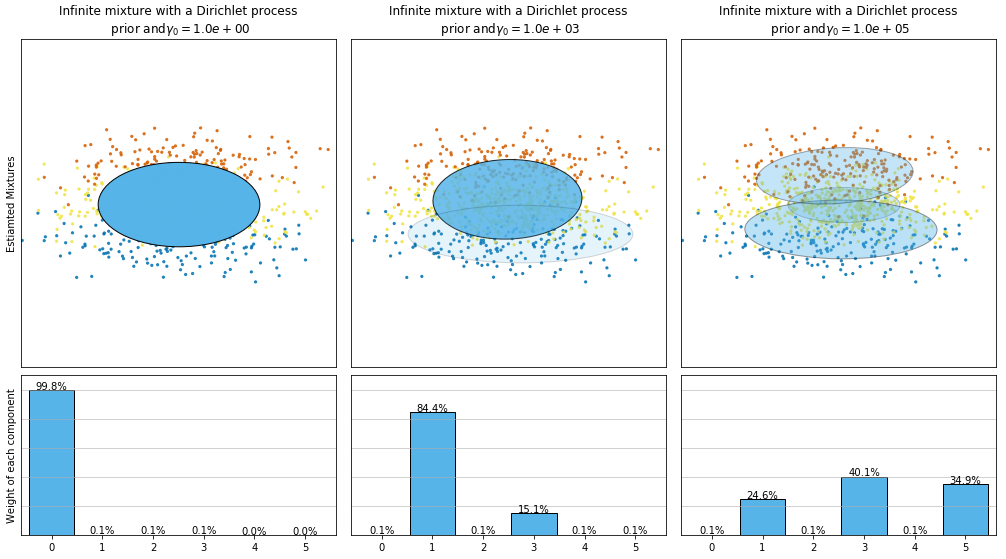

In [6]:
import matplotlib.gridspec as gridspec
from sklearn.mixture import BayesianGaussianMixture

def plot_ellipses(ax,weights,means,covars):
    for n in range(means.shape[0]):
        eig_vals,eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1],unit_eig_vec[0])
        # ellipse needs degrees
        angle = 180 * angle /np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n],eig_vals[0],eig_vals[1],
                                 180 + angle,edgecolor='k')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)
        
def plot_results(ax1,ax2,estiamtor,X,y,title,plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:,0],X[:,1],s=5,marker='o',color=colors[y],alpha=0.8)
    ax1.set_xlim(-2.,2.)
    ax1.set_ylim(-3.,3.)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1,estimator.weights_,estimator.means_,
                 estimator.covariances_)
    
    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True,alpha=0.7)
    for k,w in enumerate(estiamtor.weights_):
        ax2.bar(k,w,width=0.9,color='#56B4E9',align='center',edgecolor='k')
        ax2.text(k,w+0.007,'%.1f%%'%(w*100.),horizontalalignment='center')
        
    ax2.set_xlim(-0.6,2 * n_components - 0.4)
    ax2.set_ylim(0.,1.1)
    ax2.tick_params(axis='y',which='both',left='off',right='off',labelleft='off')
    ax2.tick_params(axis='x',which='both',top='off')
    
    if plot_title:
        ax1.set_ylabel('Estiamted Mixtures')
        ax2.set_ylabel('Weight of each component')
        
#parameters of the dataset
random_state,n_components,n_features = 2 ,3,2
colors = np.array(['#0072B2','#F0E442','#D55E00'])
covars = np.array([[[.7,.0],[.0,.1]],
                  [[.5,.0],[.0,.1]],
                  [[.5,.0],[.0,.1]]])
samples = np.array([200,500,200])
means = np.array([[.0,-.70],[.0,0],[.0,.70]])

# mean_precision_prior = 0.8
estimators = [
    ("Finite mixture with a Dirichlet distribution\nprior and "
     r"$\gamma_0=$", BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state), [0.001, 1, 1000]),
    ("Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
     BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_process",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state), [1, 1000, 100000])]

# Generate data
rng = np.random.RandomState(random_state)
X = np.vstack([
    rng.multivariate_normal(means[j], covars[j], samples[j])
    for j in range(n_components)])
y = np.concatenate([j * np.ones(samples[j], dtype=int)
                    for j in range(n_components)])

# Plot results in two different figures
for (title, estimator, concentrations_prior) in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(bottom=.04, top=0.90, hspace=.05, wspace=.05,
                        left=.03, right=.99)

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(plt.subplot(gs[0:2, k]), plt.subplot(gs[2, k]), estimator,
                     X, y, r"%s$%.1e$" % (title, concentration),
                     plot_title=k == 0)

plt.show()   

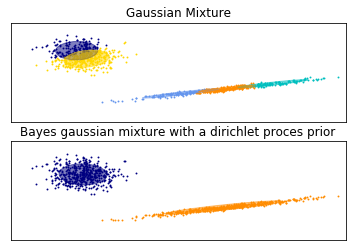

In [8]:
import itertools
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(['navy','c','cornflowerblue','gold',
                             'darkorange'])

def plot_results(X,Y_,means,covariances,index,title):
    splot = plt.subplot(2,1,1+index)
    for i,(mean,covar,color) in enumerate(zip(means,covariances,color_iter)):
        v,w = linalg.eigh(covar)
        v = 2. * np.sqrt(2) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_==i,0],X[Y_==i,1],.8,color=color)
        
        # plot an ellipse to show the gaussian component
        angle = np.arctan(u[1]/u[0])
        angle = 180. * angle /np.pi
        ell = mpl.patches.Ellipse(mean,v[0],v[1],180.+ angle,color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xlim(-9.,5)
    plt.ylim(-3.,6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

n_samples = 500
np.random.seed(0)
C = np.array([[0,-0.1],[1.7,.4]])
X = np.r_[np.dot(np.random.randn(n_samples,2),C), 
          .7 * np.random.randn(n_samples,2) + np.array([-6,3])]
# fit a gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5,covariance_type='full').fit(X)
plot_results(X,gmm.predict(X),gmm.means_,gmm.covariances_,0,'Gaussian Mixture')
# fit a dirichlet process gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,covariance_type='full').fit(X)
plot_results(X,dpgmm.predict(X),dpgmm.means_,dpgmm.covariances_,1,'Bayes gaussian mixture with a dirichlet proces prior')

plt.show()


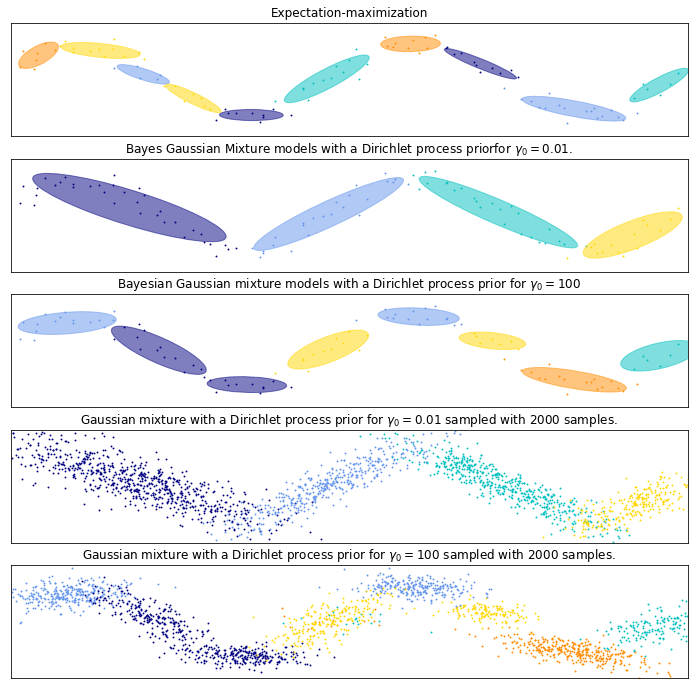

In [11]:
import itertools
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(['navy','c','cornflowerblue','gold',
                             'darkorange'])

def plot_results(X,Y,means,covariances,index,title):
    splot = plt.subplot(5,1,1+index)
    for i, (mean,covar,color) in enumerate(zip(means,covariances,color_iter)):
        v,w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0]/ linalg.norm(w[0])
        if not np.any(Y==i):
            continue
        plt.scatter(X[Y==i,0],X[Y==i,1],.8,color=color)
        
        #plot an ellipse to show the gaussian component
        angle = np.arctan(u[1]/u[0])
        angle = 180 * angle / np.pi
        ell = mpl.patches.Ellipse(mean,v[0],v[1], 180. + angle,color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xlim(-6,4. * np.pi - 6.)
    plt.ylim(-5,5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

def plot_samples(X,Y,n_components,index,title):
    plt.subplot(5,1,4+index)
    for i ,color in zip(range(n_components),color_iter):
        if not np.any(Y==i):
            continue
        plt.scatter(X[Y==i,0],X[Y==i,1],.8,color=color)
    plt.xlim(-6.,4. * np.pi - 6.)
    plt.ylim(-5,5)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    
n_samples = 100
np.random.seed(0)
X = np.zeros((n_samples,2))
step = 4. * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6
    X[i,0] = x + np.random.normal(0,0.1)
    X[i,1] = 3. * (np.sin(x) + np.random.normal(0,0.2))
    
plt.figure(figsize=(10,10))
plt.subplots_adjust(bottom=.04,top=0.95,hspace=.2,wspace=.05,
                   left=.03,right=.97)
# fit a gaussian mixture with em using ten components
gmm = mixture.GaussianMixture(n_components=10,covariance_type='full',
                             max_iter=100).fit(X)
plot_results(X,gmm.predict(X),gmm.means_,gmm.covariances_,0,'Expectation-maximization')

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10,covariance_type='full',weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2,covariance_prior=1e0 * np.eye(2),
    init_params='random',max_iter=100,random_state=2).fit(X)
plot_results(X,dpgmm.predict(X),dpgmm.means_,dpgmm.covariances_,1,
            'Bayes Gaussian Mixture models with a Dirichlet process prior'
            'for $\gamma_0=0.01$.')
X_s,y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s,y_s,dpgmm.n_components,0,
            "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=0.01$ sampled with $2000$ samples." )

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 1,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=100$ sampled with $2000$ samples.")

plt.show()

Manifold learning

standard: 0.46 sec
ltsa: 0.76 sec
hessian: 1.5 sec
modified: 0.85 sec
Isomap : 1 sec
MDS: 11 sec
SpectralEmbedding: 0.53 sec
T-sne: 62 sec


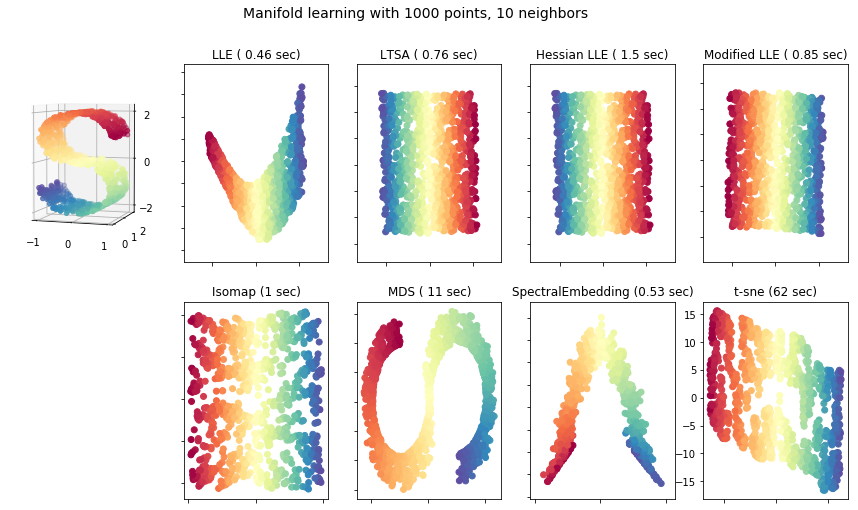

In [6]:
from time import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn import datasets

Axes3D

n_points = 1000
X,color = datasets.samples_generator.make_s_curve(n_points,random_state=0)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15,8))
plt.suptitle('Manifold learning with %i points, %i neighbors'
            %(1000,n_neighbors),fontsize=14)

ax = fig.add_subplot(251,projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2],c=color,cmap=plt.cm.Spectral)
ax.view_init(4,-72)

methods = ['standard','ltsa','hessian','modified']
labels = ['LLE','LTSA','Hessian LLE','Modified LLE']

for i,method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print('%s: %.2g sec'%(methods[i],t1-t0))
    
    ax = fig.add_subplot(252+i)
    plt.scatter(Y[:,0],Y[:,1],c=color,cmap=plt.cm.Spectral)
    plt.title('%s ( %.2g sec)'%(labels[i],t1-t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors,n_components).fit_transform(X)
t1 = time()
print('Isomap : %.2g sec' % (t1-t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:,0],Y[:,1],c=color,cmap=plt.cm.Spectral)
plt.title('Isomap (%.2g sec)'%(t1-t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
mds = manifold.MDS(n_components,max_iter=100,n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print('MDS: %.2g sec' %(t1-t0))
ax= fig.add_subplot(258)
plt.scatter(Y[:,0],Y[:,1],c=color,cmap=plt.cm.Spectral)
plt.title('MDS ( %.2g sec)' % (t1-t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                               n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print('SpectralEmbedding: %.2g sec' % (t1-t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:,0],Y[:,1],c=color,cmap=plt.cm.Spectral)
plt.title('SpectralEmbedding (%.2g sec)' % (t1-t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components,init='pca',random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print('T-sne: %.2g sec' % (t1 -t0))
ax = fig.add_subplot(2,5,10)
plt.scatter(Y[:,0],Y[:,1],c=color,cmap=plt.cm.Spectral)
plt.title('t-sne (%.2g sec)' % (t1-t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()



Computing random projection
Computing PCA projection
Computing linear discriminant analysis projection
Computing isomap embedding 
Done.
computing LLE embedding
Done. Reconstruction error; 1.63544e-06
Computing modified LLE embedding
Done. Reconstruction error: 0.359792
Computing hessian lle embedding
Done. Reconstruction error: 0.212802
Computing LTSA embedding
Done.Reconstruction error: 0.212802
Computing mds embedding
Done. Stress: 138112385.940766
Computing totally random trees embedding
Computing Spectral embedding
Computing t-SNE embedding


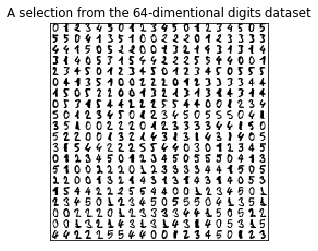

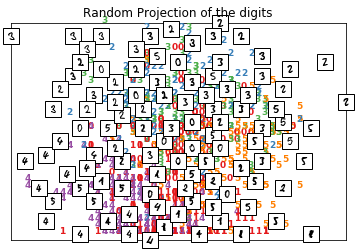

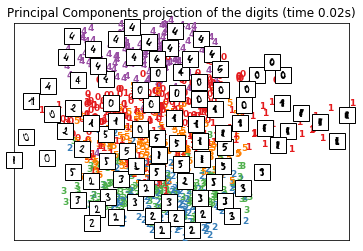

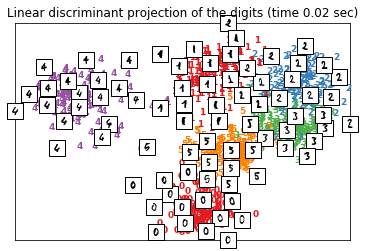

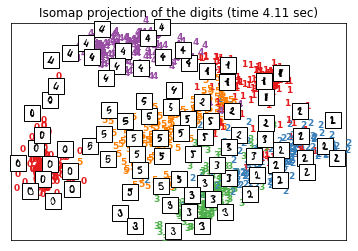

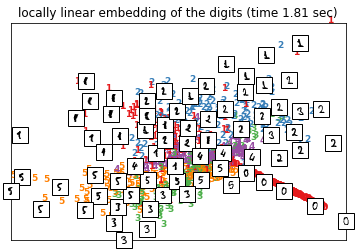

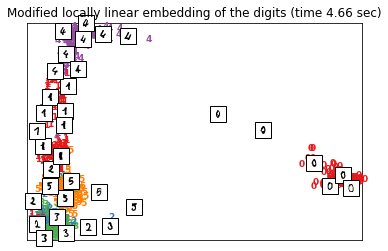

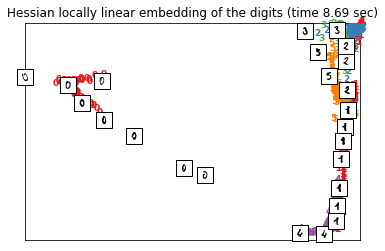

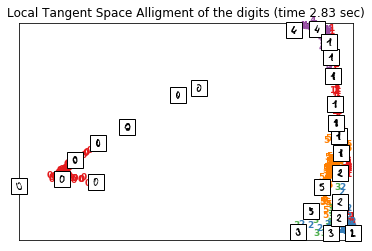

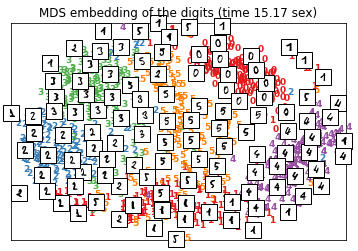

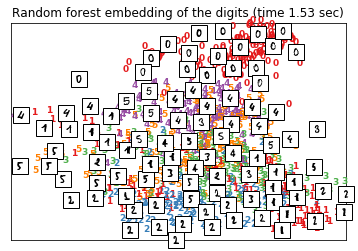

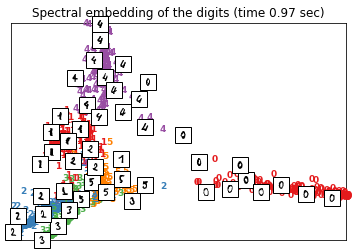

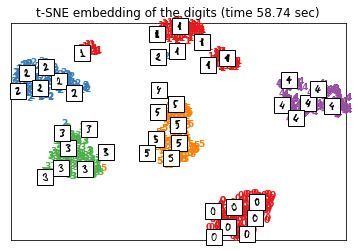

In [12]:
from time import time
from matplotlib import offsetbox
from sklearn import (manifold,datasets,decomposition,ensemble,
                    discriminant_analysis,random_projection)

digits = datasets.load_digits(n_class=6)
X ,y = digits.data,digits.target
n_samples,n_features = X.shape
n_neighbors = 30

# scale and visualize the embedding vectors
def plot_embedding(X,title=None):
    x_min,x_max = np.min(X,0),np.max(X,0)
    X = (X - x_min )/ ( x_max - x_min)
    
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i,0],X[i,1],str(digits.target[i]),
                  color=plt.cm.Set1(y[i]/10.),
                  fontdict={'weight':'bold','size':9})
    if hasattr(offsetbox,'AnnotationBbox'):
        shown_images = np.array([[1.,1.]])
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2 ,1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images,[X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i],cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]),plt.yticks([])
    if title is not None:
        plt.title(title)
# plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row,10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1 
        img[ix:ix + 8,iy:iy + 8] = X[i * n_img_per_row +j].reshape((8,8))

plt.imshow(img,cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimentional digits dataset')

# random 2d projection using a random unitary matrix
print('Computing random projection')
rp = random_projection.SparseRandomProjection(n_components=2,random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected,'Random Projection of the digits')

# Projection on to the first 2 principal components
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

# projection on to the first 2 linear discriminant components
print('Computing linear discriminant analysis projection')
X2 = X.copy()
X2.flat[::X.shape[1]+ 1] += 0.01 # make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2).fit_transform(X2,y)
plot_embedding(X_lda,'Linear discriminant projection of the digits (time %.2f sec)' %(time()-t0))

# isomap projection of the digits dataset
print('Computing isomap embedding ')
t0 = time()
X_iso = manifold.Isomap(n_neighbors,n_components=2).fit_transform(X)
print('Done.')
plot_embedding(X_iso,'Isomap projection of the digits (time %.2f sec)'%(time()-t0))

# locally linear embedding of the digits dataset
print('computing LLE embedding')
clf = manifold.LocallyLinearEmbedding(n_neighbors,n_components=2,method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print('Done. Reconstruction error; %g'%clf.reconstruction_error_)
plot_embedding(X_lle,'locally linear embedding of the digits (time %.2f sec)'%(time()-t0))

# modified locally linear embedding of the digits dataset
print('Computing modified LLE embedding')
clf = manifold.LocallyLinearEmbedding(n_neighbors,n_components=2,method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print('Done. Reconstruction error: %g'%clf.reconstruction_error_)
plot_embedding(X_mlle,'Modified locally linear embedding of the digits '
              '(time %.2f sec)' % (time() - t0))

#hlle embedding of the digits dataset
print('Computing hessian lle embedding')
clf = manifold.LocallyLinearEmbedding(n_neighbors,n_components=2,method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
print('Done. Reconstruction error: %g'%clf.reconstruction_error_)
plot_embedding(X_hlle,'Hessian locally linear embedding of the digits (time %.2f sec)'%(time()-t0))

# ltsa embedding of the digits dataset
print('Computing LTSA embedding')
clf = manifold.LocallyLinearEmbedding(n_neighbors,n_components=2,method='ltsa')
t0 =time()
X_ltsa = clf.fit_transform(X)
print('Done.Reconstruction error: %g' % clf.reconstruction_error_)
plot_embedding(X_ltsa,'Local Tangent Space Alligment of the digits (time %.2f sec)'%(time()-t0))

# mds embedding of the digits dataset
print('Computing mds embedding')
clf = manifold.MDS(n_components=2,n_init=1,max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print('Done. Stress: %f' %clf.stress_)
plot_embedding(X_mds,'MDS embedding of the digits (time %.2f sex)'%(time()-t0))

# random trees embedding of the digits dataset
print('Computing totally random trees embedding')
hasher = ensemble.RandomTreesEmbedding(n_estimators=200,random_state=0,max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)
plot_embedding(X_reduced,'Random forest embedding of the digits (time %.2f sec)'%(time()-t0))

# spectral embedding of the digits dataset
print('Computing Spectral embedding')
embedder = manifold.SpectralEmbedding(n_components=2,random_state=0,
                                     eigen_solver='arpack')
t0 = time()
X_se = embedder.fit_transform(X)
plot_embedding(X_se,'Spectral embedding of the digits (time %.2f sec)'%(time()-t0))

# t-SNE embedding of thd digits dataset
print('Computing t-SNE embedding')
tsne = manifold.TSNE(n_components=2,init='pca',random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,'t-SNE embedding of the digits (time %.2f sec)' %(time()-t0))

plt.show()

    
    
    

E:\anaconda\anaconda\lib\site-packages\ipykernel\__main__.py:50: RuntimeWarning: divide by zero encountered in true_divide


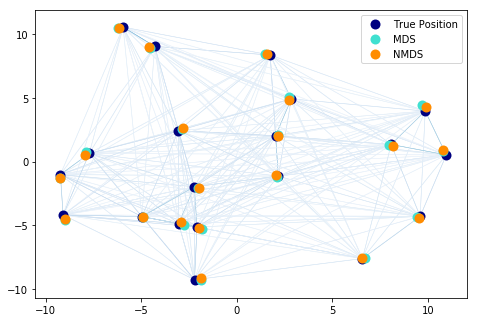

In [18]:
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0,20,2*n_samples).astype(np.float)
X_true = X_true.reshape((n_samples,2))
# center the data
X_true -= X_true.mean()

similarities = euclidean_distances(X_true)

# add noise to the similarities
noise = np.random.rand(n_samples,n_samples)
noise = noise + noise.T
np.fill_diagonal(noise,0)
#noise[np.arange(noise.shape[0]),np.arange(noise.shape[0])] = 0
similarities += noise

mds = manifold.MDS(n_components=2,max_iter=3000,eps=1e-9,random_state=seed,
                  dissimilarity='precomputed')
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2,metric=False,max_iter=3000,eps=1e-12,
                   dissimilarity='precomputed',random_state=seed,n_init=1)
npos = nmds.fit_transform(similarities,init=pos)
#rescale the data
pos *= np.sqrt((X_true **2).sum()) / np.sqrt((pos **2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos **2).sum())

# rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)
npos = clf.fit_transform(npos)

fig = plt.figure(1)
ax = plt.axes([0.,0.,1.,1.])

s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color='navy', s=s, lw=0,
            label='True Position')
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
plt.scatter(npos[:, 0], npos[:, 1], color='darkorange', s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0


# plot the  edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(0.5 * np.ones(len(segments)))
ax.add_collection(lc)

plt.show()


In [9]:
noise

array([[ 0.        ,  1.47022984,  0.82733803,  0.64623452,  0.6563956 ,
         1.22396779,  0.66553828,  0.93966691,  0.73988624,  0.8291829 ,
         1.40516651,  0.44199552,  0.91318566,  1.09788202,  0.55774731,
         1.41076048,  1.21084824,  1.03877918,  1.01028606,  1.35528985],
       [ 1.47022984,  0.        ,  0.26483727,  0.46255482,  1.43650666,
         1.14641449,  1.03442683,  1.2628911 ,  0.6076486 ,  1.31743288,
         1.07485852,  1.21946927,  0.6544066 ,  0.76462581,  0.35798852,
         1.41764257,  0.67769004,  1.15860981,  0.78976251,  1.42333908],
       [ 0.82733803,  0.26483727,  0.        ,  1.05093999,  0.91704771,
         1.82384082,  1.06812951,  1.52925434,  0.87615124,  1.45832829,
         0.67957546,  1.21754005,  0.50028019,  1.49404423,  1.12745064,
         0.98601852,  1.66095426,  1.10817167,  1.25114401,  1.10019964],
       [ 0.64623452,  0.46255482,  1.05093999,  0.        ,  1.39600312,
         1.34986404,  0.99133211,  1.3090368 ,  

# Cluster

E:\anaconda\anaconda\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
E:\anaconda\anaconda\lib\site-packages\sklearn\cluster\hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
E:\anaconda\anaconda\lib\site-packages\sklearn\cluster\hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
E:\anaconda\anaconda\lib\site-packages\sklearn\cluster\hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 78 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
E:\anaconda\anaconda\lib\site-packages\sklearn\cluster\hierarchi

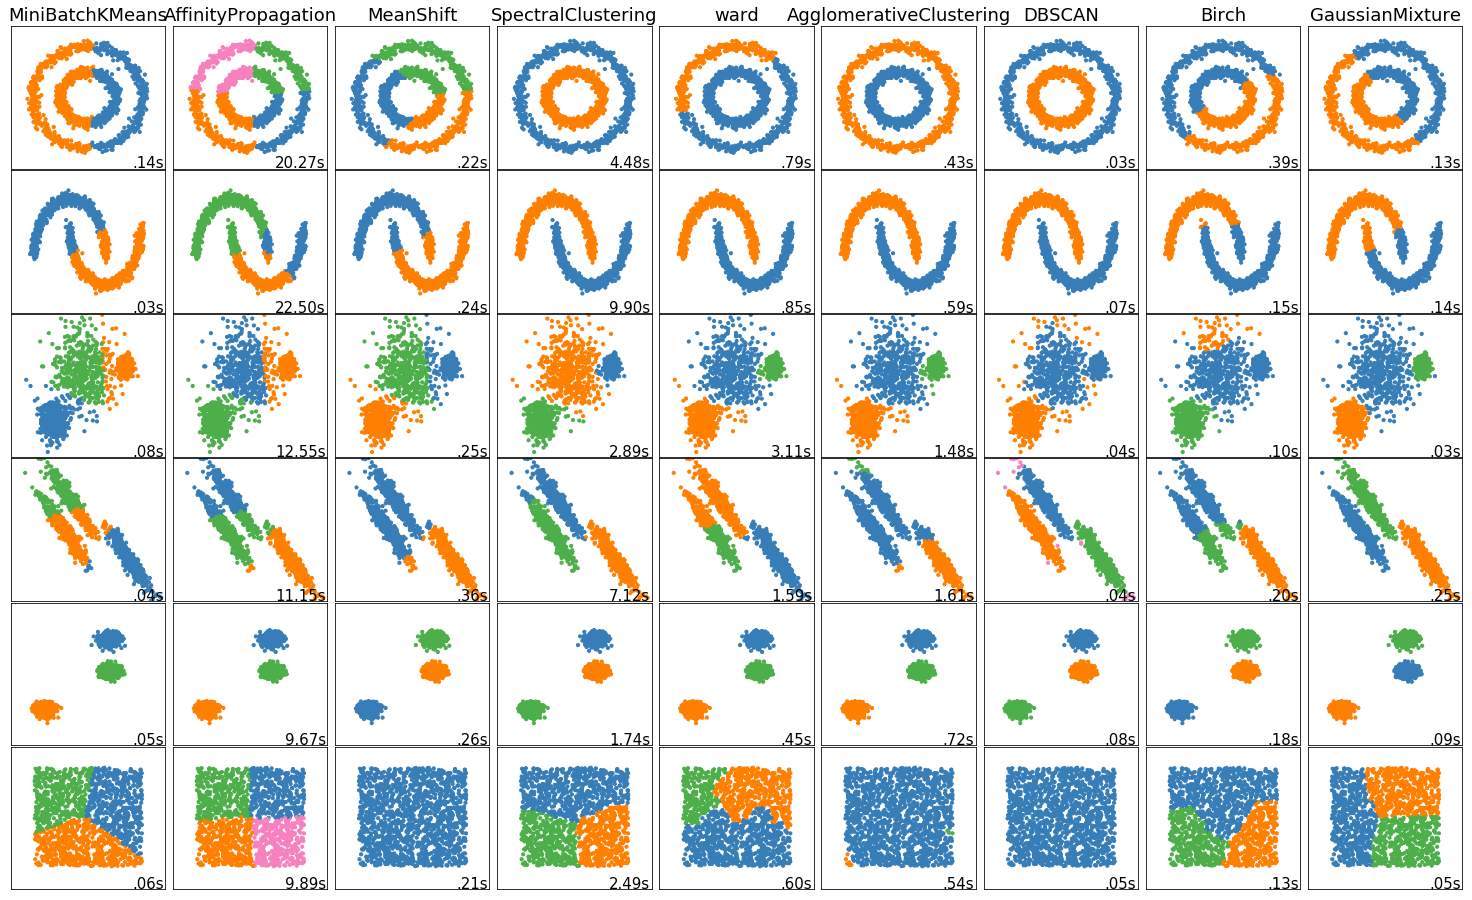

In [5]:
import time
import warnings
from sklearn import cluster,datasets,mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle,islice

np.random.seed(0)

# generate the datra
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples,factor=.5,
                                     noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples,noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples,random_state=8)
no_structure = np.random.rand(n_samples,2),None

# Anisotropicly distributed data
random_state = 170
X,y = datasets.make_blobs(n_samples=n_samples,random_state=random_state)
transformation = [[0.6,-0.6],[-0.4,0.8]]
X_aniso = np.dot(X,transformation)
aniso = (X_aniso,y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                            cluster_std=[1.0,2.5,0.5],
                            random_state=random_state)

# set up cluster parameters
plt.figure(figsize=(9 * 2 +3,12.5))
plt.subplots_adjust(left=.02,right=.98,bottom=.001,top=.96,wspace=.05,hspace=.01)

plot_num = 1

default_base = {
    'quantile':.3,
    'eps':.3,
    'damping':.9,
    'preference':-200,
    'n_neighbors':10,
    'n_clusters':3
}
datasets = [
    (noisy_circles,{'damping':.77,'preference':-240,'quantile':.2,'n_clusters':2}),
    (noisy_moons,{'damping':.75,'preference':-220,'n_clusters':2}),
    (varied,{'eps':.18,'n_neighbors':2}),
    (aniso,{'eps':.15,'n_neighbors':2}),
    (blobs,{}),
    (no_structure,{})
]

for i_dataset,(dataset,algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)
    
    X,y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    # estiamte bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X,quantile=params['quantile'])
    
    # connectivity martix for structure ward
    connectivity = kneighbors_graph(X,n_neighbors=params['n_neighbors'],include_self=False)
    #make connectivity symmetric
    conncetivity = 0.5 * (connectivity + connectivity.T)
    
    # create cluster objects
    ms = cluster.MeanShift(bandwidth=bandwidth,bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'],linkage='ward',connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'],
        eigen_solver='arpack',affinity='nearest_neighbors')
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'],preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage='average',affinity='cityblock',
        n_clusters=params['n_clusters'],connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'],covariance_type='full')
    
    clustering_algorithms = (
        ('MiniBatchKMeans',two_means),
        ('AffinityPropagation',affinity_propagation),
        ('MeanShift',ms),
        ('SpectralClustering',spectral),
        ('ward',ward),
        ('AgglomerativeClustering',average_linkage),
        ('DBSCAN',dbscan),
        ('Birch',birch),
        ('GaussianMixture',gmm)
    )
    
    for name,algorithm in clustering_algorithms:
        t0 = time.time()
        
        # catch warning related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                'ignore',
                message='the number of connected components of the '+
                'connectivity matrix is [0-9]{1,2}' +
                ' > 1 completing it to avoid stopping the tre early.',
                category=UserWarning)
            warnings.filterwarnings(
                'ignore',
                message='Graph is not fully connected, spectral embedding'+
                'may not work as expected.',
                category=UserWarning)
            algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm,'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
        
        plt.subplot(len(datasets),len(clustering_algorithms),plot_num)
        if i_dataset == 0:
            plt.title(name,size=18)
            
        colors = np.array(list(islice(cycle(['#377eb8','#ff7f00','#4daf4a',
                                            '#f781bf','#a656628','#984ea3',
                                            '#999999','#e41a1c','#dede00']),
                                     int(max(y_pred)+1))))
        plt.scatter(X[:,0],X[:,1],s=10,color=colors[y_pred])
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99,.01,('%.2fs'%(t1-t0)).lstrip('0'),
                transform=plt.gca().transAxes,size=15,
                horizontalalignment='right')
        plot_num += 1
        
plt.show()
            
        
            

n_digits: 10,	 n_samples 1797,	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	2.38s	69432	0.602	0.650	0.625	0.465	0.598	0.146
random   	1.28s	69694	0.669	0.710	0.689	0.553	0.666	0.147
pca-based	0.19s	70804	0.671	0.698	0.684	0.561	0.668	0.118
__________________________________________________________________________________


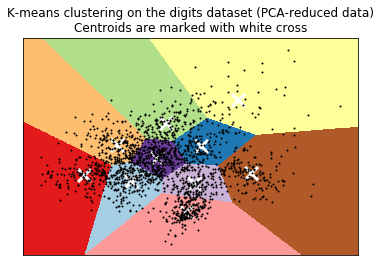

In [15]:
from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples,n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print('n_digits: %d,\t n_samples %d,\t n_features %d'%(n_digits,n_samples,n_features))

print( 82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator,name,data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
         %(name,(time()-t0),estimator.inertia_,
          metrics.homogeneity_score(labels,estimator.labels_),
          metrics.completeness_score(labels,estimator.labels_),
          metrics.v_measure_score(labels,estimator.labels_),
          metrics.adjusted_rand_score(labels,estimator.labels_),
          metrics.adjusted_mutual_info_score(labels,estimator.labels_),
          metrics.silhouette_score(data,estimator.labels_,metric='euclidean',
                                  sample_size=sample_size)))
bench_k_means(KMeans(init='k-means++',n_clusters=n_digits,n_init=10),
             name='k-means++',data=data)
bench_k_means(KMeans(init='random',n_clusters=n_digits,n_init=10),
             name='random',data=data)

pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_,n_clusters=n_digits,n_init=1),
             name='pca-based',data=data)
print('_' * 82)

#visualize the results on pca-reduced data
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++',n_clusters=n_digits,n_init=10)
kmeans.fit(reduced_data)
#
h = 0.02
x_min,x_max = reduced_data[:,0].min() -1 ,reduced_data[:,0].max() +1
y_min,y_max = reduced_data[:,1].min() -1 ,reduced_data[:,1].max() +1
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))

# 
Z = kmeans.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z,interpolation='nearest',
          extent=(xx.min(),xx.max(),yy.min(),yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto',origin='lower')
plt.plot(reduced_data[:,0],reduced_data[:,1],'k.',markersize=2)
#plot the centroidsa as a white x
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=169,lw=3,
           color='w')
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


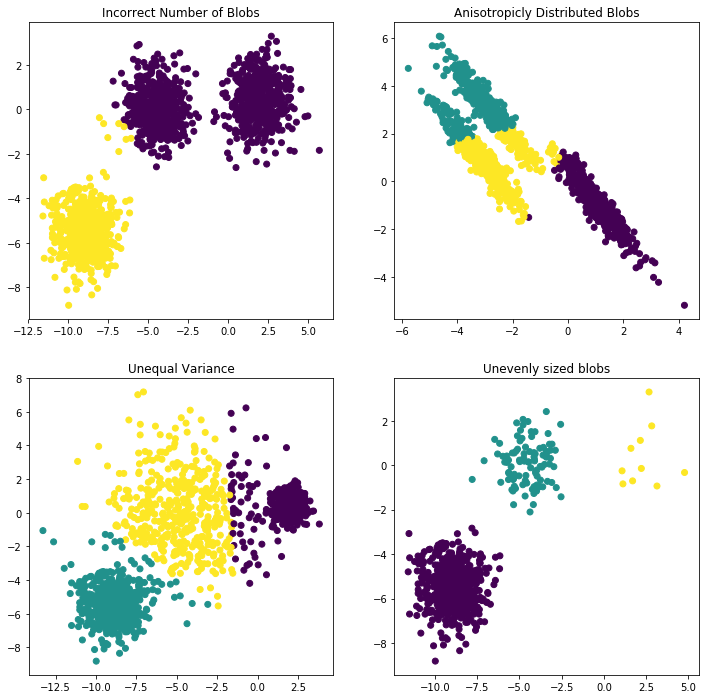

In [17]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12,12))

n_samples = 1500
random_state = 170
X,y = make_blobs(n_samples=n_samples,random_state=random_state)

# incorrect number of clusters
y_pred = KMeans(n_clusters=2,random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:,0],X[:,1],c=y_pred)
plt.title('Incorrect Number of Blobs')

# Anisotropicly distributed data
transformation = [[0.60834549,-0.63667341],[-0.40887718,0.85253229]]
X_aniso = np.dot(X,transformation)
y_pred = KMeans(n_clusters=3,random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:,0],X_aniso[:,1],c=y_pred)
plt.title('Anisotropicly Distributed Blobs')

# different variance
X_varied,y_varied = make_blobs(n_samples=n_samples,
                              cluster_std=[1.0,2.5,0.5],
                              random_state=random_state)
y_pred = KMeans(n_clusters=3,random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:,0],X_varied[:,1],c=y_pred)
plt.title('Unequal Variance')

# Unevenly sized blobs
X_filtered = np.vstack((X[y==0][:500],X[y==1][:100],X[y==2][:10]))
y_pred = KMeans(n_clusters=3,random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:,0],X_filtered[:,1],c=y_pred)
plt.title('Unevenly sized blobs')
plt.show()

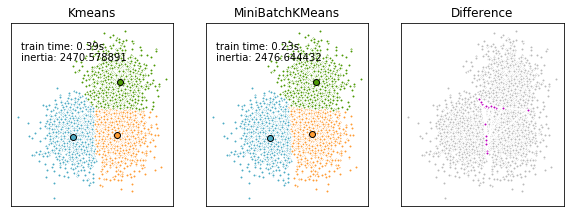

In [19]:
from sklearn.cluster import MiniBatchKMeans,KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs
import time

# generate sample data
np.random.seed(0)
batch_size = 45
centers = [[1,1],[-1,-1],[1,-1]]
n_clusters = len(centers)
X,labels_true = make_blobs(n_samples=3000,centers=centers,cluster_std=0.7)

#compute clustering with means
k_means = KMeans(init='k-means++',n_clusters=3,n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# compute clustering with Minibatchkmeans
mbk = MiniBatchKMeans(init='k-means++',n_clusters=3,batch_size=batch_size,
                     n_init=10,max_no_improvement=10,verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

# plot result
fig = plt.figure(figsize=(8,3))
fig.subplots_adjust(left=0.02,right=0.98,bottom=0.05,top=0.9)
colors = ['#4EACC5','#FF9C34','#4E9A06']

#
k_means_cluster_centers = np.sort(k_means.cluster_centers_,axis=0)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_,axis=0)
k_means_labels = pairwise_distances_argmin(X,k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X,mbk_means_cluster_centers)
order = pairwise_distances_argmin(k_means_cluster_centers,mbk_means_cluster_centers)

# kmeans
ax = fig.add_subplot(131)
for k,col in zip(range(n_clusters),colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members,0],X[my_members,1],'w',
           markerfacecolor=col,marker='.')
    ax.plot(cluster_center[0],cluster_center[1],'o',markerfacecolor=col,
           markeredgecolor='k',markersize=6)
ax.set_title('Kmeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5,1.8,'train time: %.2fs\ninertia: %f'%(t_batch,k_means.inertia_))

# Minibatchkmeans
ax = fig.add_subplot(132)
for k,col in zip(range(n_clusters),colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members,0],X[my_members,1],'w',
           markerfacecolor=col,marker='.')
    ax.plot(cluster_center[0],cluster_center[1],'o',markerfacecolor=col,
           markeredgecolor='k',markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5,1.8,'train time: %.2fs\ninertia: %f'%(t_mini_batch,mbk.inertia_))

# initialise the different array to all false
different = (mbk_means_labels ==4)
ax = fig.add_subplot(133)
for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))
    
identic = np.logical_not(different)
ax.plot(X[identic,0],X[identic,1],'w',markerfacecolor='#bbbbbb',marker='.')
ax.plot(X[different,0],X[different,1],'w',markerfacecolor='m',marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()


In [20]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(data_home='E:/python_work/handson_ml/datasets/',subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words='english', alternate_sign=False,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english',
                                       alternate_sign=False, norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Automatically created module for IPython interactive environment
Usage: __main__.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


2017-11-03 21:35:47,899 INFO Downloading 20news dataset. This may take a few minutes.
2017-11-03 21:35:47,916 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 4.600263s
n_samples: 3387, n_features: 10000

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=False)
done in 1.207s

Homogeneity: 0.567
Completeness: 0.595
V-measure: 0.580
Adjusted Rand-Index: 0.558
Silhouette Coefficient: 0.008

Top terms per cluster:
Cluster 0: graphics university com thanks image posting host nntp file files
Cluster 1: keith sgi livesey caltech morality objective com mathew solntze wpd
Cluster 2: space nasa access henry digex com pat toronto gov alaska
Cluster 3: god com sandvik people jesus don article bible kent christian


Learning the dictionary...
Partial fit of  100 out of 2400
Partial fit of  200 out of 2400
[MiniBatchKMeans] Reassigning 16 cluster centers.
Partial fit of  300 out of 2400
Partial fit of  400 out of 2400
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Partial fit of 2200 out of 2400
Partial fit of 2300 out of 2400
Partial fit of 2400 out of 2400
done in 16.09s.


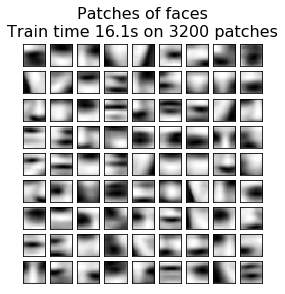

In [22]:
import time
from sklearn import datasets
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

faces = datasets.fetch_olivetti_faces(data_home='E:/python_work/handson_ml/datasets')

# learn the dictionary of images
print('Learning the dictionary...')
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81,random_state=rng,verbose=True)
patch_size = (20,20)

buffer = []
index = 1
t0 = time.time()

# the online learning part: cycle over the dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img,patch_size,max_patches=50,random_state=rng)
        data = np.reshape(data,(len(data),-1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer,axis=0)
            data -= np.mean(data,axis=0)
            data /= np.std(data,axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print('Partial fit of %4i out of %i'%(index,6*len(faces.images)))
dt = time.time() - t0
print('done in %.2fs.'%dt)

# plot the results
plt.figure(figsize=(4,4))
for i ,patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())


plt.suptitle('Patches of faces\nTrain time %.1fs on %d patches' %
             (dt, 8 * len(faces.images)), fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

Affinity propagation

Estimated number of cluster: 3 
Homogeneity : 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index : 0.912
Adjuste Mutual Information: 0.871
Silhouette Coefficient: 0.753


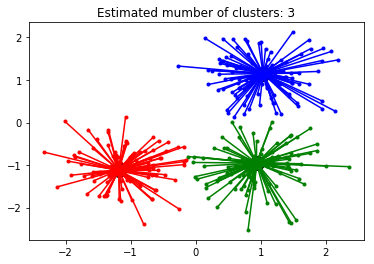

In [9]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from itertools import cycle
# generate sample data
centers = [[1,1],[-1,-1],[1,-1]]
X,labels_true = make_blobs(n_samples=300,centers=centers,cluster_std=0.5,random_state=0)

# compute affinity propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of cluster: %d '%n_clusters_)
print('Homogeneity : %0.3f' % metrics.homogeneity_score(labels_true,labels))
print('Completeness: %0.3f' % metrics.completeness_score(labels_true,labels))
print('V-measure: %0.3f' % metrics.v_measure_score(labels_true,labels))
print('Adjusted Rand Index : %0.3f' % metrics.adjusted_rand_score(labels_true,labels))
print('Adjuste Mutual Information: %0.3f' % metrics.adjusted_mutual_info_score(labels_true,labels))
print('Silhouette Coefficient: %0.3f' % metrics.silhouette_score(X,labels,metric='sqeuclidean'))

# plot result
plt.close('all')
plt.figure()
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k ,col in zip(range(n_clusters_),colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members,0],X[class_members,1],col+'.')
    plt.plot(cluster_center[0],cluster_center[1],'o',markerfacecolor=col,
            markeredgecolor='k',markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0],x[0]],[cluster_center[1],x[1]],col)
plt.title('Estimated mumber of clusters: %d' % n_clusters_)
plt.show()
    

In [10]:
af.cluster_centers_indices_.shape

(3,)

Mean shift

number of estimated of clusters: 3 


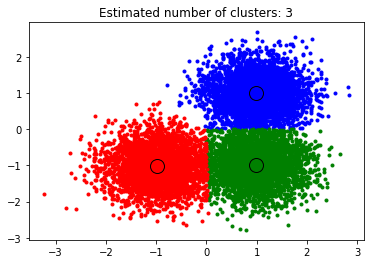

In [11]:
from sklearn.cluster import MeanShift ,estimate_bandwidth
from sklearn.datasets import make_blobs
from itertools import cycle
#generate sample data
centers = [[1,1],[-1,-1],[1,-1]]
X,_ = make_blobs(n_samples=10000,centers=centers,cluster_std=0.5)
# the following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X,quantile=0.2,n_samples=500)

ms = MeanShift(bandwidth=bandwidth,bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print('number of estimated of clusters: %d ' % n_clusters_)

#plot the result
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k,col in zip(range(n_clusters_),colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members,0],X[my_members,1],col+'.')
    plt.plot(cluster_center[0],cluster_center[1],'o',markerfacecolor=col,
            markeredgecolor='k',markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Spectral clustering

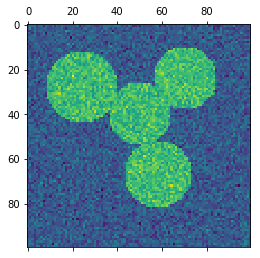

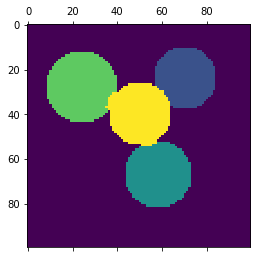

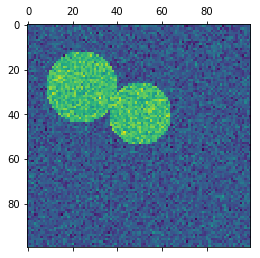

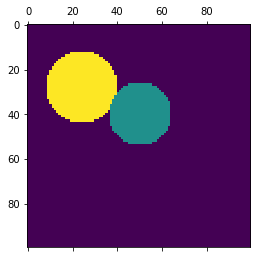

In [15]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img,mask=mask)
graph.data = np.exp(-graph.data/graph.data.std())

labels = spectral_clustering(graph,n_clusters=2,eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

plt.show()

In [17]:
x.shape

(100, 100)

Spectral clustering: kmeans, 38.56s
Spectral clustering: discretize, 41.59s


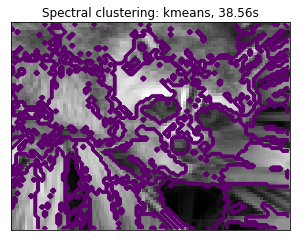

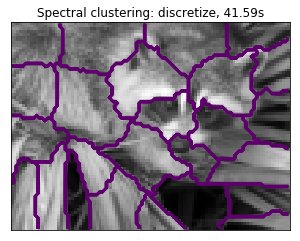

In [19]:
import time
import scipy as sp
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

try:
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

face = sp.misc.imresize(face,0.10) / 255
graph = image.img_to_graph(face)

beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

N_REGIONS = 25

for assign_labels in ('kmeans','discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph,n_clusters=N_REGIONS,
                                assign_labels=assign_labels,random_state=1)
    t1 = time.time()
    labels = labels.reshape(face.shape)
    
    plt.figure(figsize=(5,5))
    plt.imshow(face,cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels==l,contours=1,colors=[plt.cm.spectral(1/float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = 'Spectral clustering: %s, %.2fs'%(assign_labels,(t1-t0))
    print(title)
    plt.title(title)
plt.show()

Hierarchical clustering

computing embedding
Done.
ward : 3.60s
average : 2.45s
complete : 3.25s


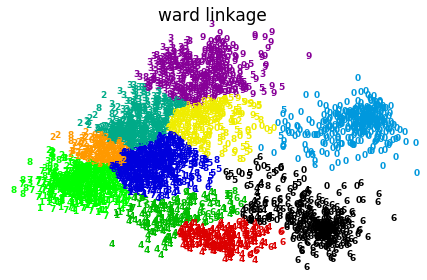

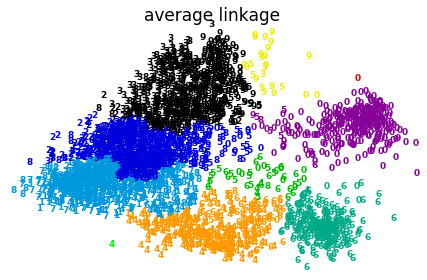

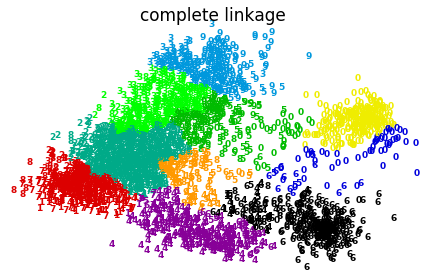

In [25]:
from time import time
from scipy import ndimage
from sklearn import manifold ,datasets
from sklearn.cluster import AgglomerativeClustering

digits = datasets.load_digits(n_class=10)
X,y = digits.data,digits.target
n_samples,n_features = X.shape

np.random.seed(0)

def nudge_images(X,y):
    shift = lambda x : ndimage.shift(x.reshape((8,8)),.3 * np.random.normal(size=2),
                                    mode='constant').ravel()
    X = np.concatenate([X,np.apply_along_axis(shift,1,X)])
    y = np.concatenate([y,y],axis=0)
    return X,y
X,y = nudge_images(X,y)

# visualize the clustering
def plot_clustering(X_red,X,labels,title=None):
    x_min,x_max = np.min(X_red,axis=0),np.max(X_red,axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    
    plt.figure(figsize=(6,4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i,0],X_red[i,1],str(y[i]),
                color=plt.cm.spectral(labels[i]/10.),
                fontdict={'weight':'bold','size':9})
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title,size=17)
    plt.axis('off')
    plt.tight_layout()
print('computing embedding')
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print('Done.')

for linkage in ('ward','average','complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)

          
plt.show()
    


Compute structured hierarchical clustering...
Elapsed time:  1.8691065311431885
Number of pixels: 7752
number of clusters: 15


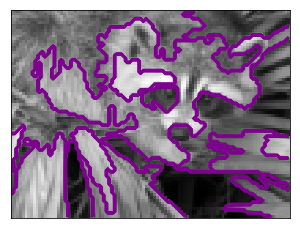

In [27]:
from time import time
import scipy as sp
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering

# generate data
try:
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)
    
#resize it to 10% of the original size to speed up the processing
face = sp.misc.imresize(face,0.10) / 255

X = np.reshape(face,(-1,1))

# define the structure A of the data. Pixel connected to their neighbors
connectivity = grid_to_graph(*face.shape)

# compute clustering
print('Compute structured hierarchical clustering...')
st = time()
n_clusters = 15
ward = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward',
                              connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_,face.shape)
print('Elapsed time: ',time() -st)
print('Number of pixels:',label.size)
print('number of clusters:',np.unique(label).size)

# plot the results on an image
plt.figure(figsize=(5,5))
plt.imshow(face,cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l ,contoures=1,
               colors=[plt.cm.spectral(1/float(n_clusters)),])
    
plt.xticks(())
plt.yticks(())
plt.show()


Compute unstructured hierachical clustering...
Elapsed time: 0.35s
Number of points: 1500
Compute structured hierarchical clustering...
Elapsed time: 0.47s
Number of points: 1500


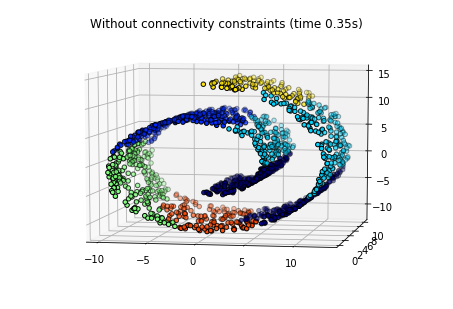

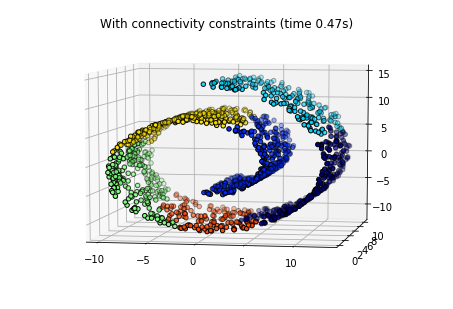

In [30]:
import time
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import kneighbors_graph
# generate data 
n_samples = 1500
noise = 0.05
X,_ = make_swiss_roll(n_samples,noise)
#make it thinner
X[:,1] *= .5

# compute clustering
print('Compute unstructured hierachical clustering...')
st = time.time()
ward = AgglomerativeClustering(n_clusters=6,linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print('Elapsed time: %.2fs' % elapsed_time)
print('Number of points: %i' %label.size)

#plot result
fig = plt.figure(1)
ax = p3.Axes3D(fig)
ax.view_init(7,-80)
for l in np.unique(label):
    ax.scatter(X[label==l,0],X[label==l,1],X[label==l,2],
              color=plt.cm.jet(np.float(l)/np.max(label+1)),
              s=20,edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)

# define the structure A of the data. Here a 10 nearest neighbors
connectivity = kneighbors_graph(X,n_neighbors=10,include_self=False)
print('Compute structured hierarchical clustering...')
st = time.time()
ward = AgglomerativeClustering(n_clusters=6,connectivity=connectivity,
                              linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print('Elapsed time: %.2fs' % elapsed_time)
print('Number of points: %i' % label.size)

#plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7,-80)
for l in np.unique(label):
    ax.scatter(X[label==l,0],X[label==l,1],X[label==l,2],
              color=plt.cm.jet(float(l)/np.max(label+1)),
              s=20,edgecolor='k')
    
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)
plt.show()





________________________________________________________________________________
[Memory] Calling sklearn.cluster.hierarchical.ward_tree...
ward_tree(array([[-0.451933, ..., -0.675318],
       ..., 
       [ 0.275706, ..., -1.085711]]), 
<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None)
________________________________________________________ward_tree - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster.hierarchical.ward_tree...
ward_tree(array([[ 0.905206, ...,  0.161245],
       ..., 
       [-0.849835, ..., -1.091621]]), 
<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None)
________________________________________________________ward_tree - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster.

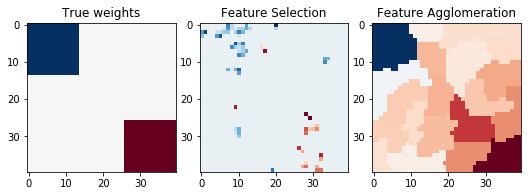

In [38]:
import shutil
import tempfile
from scipy import linalg,ndimage
from sklearn.feature_extraction.image import grid_to_graph
from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import Memory
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# generate data
n_samples = 200
size = 40 # image size
roi_size = 14
snr = 5.
np.random.seed(0)
mask = np.ones([size,size],dtype=np.bool)

coef = np.zeros((size,size))
coef[0:roi_size,0:roi_size] = -1
coef[-roi_size:,-roi_size:] = 1

X = np.random.randn(n_samples,size ** 2)
for x in X:
    x[:] = ndimage.gaussian_filter(x.reshape(size,size),sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X,coef.ravel())
noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y,2)/np.exp(snr/20.)) / linalg.norm(noise,2)
y += noise_coef * noise

# compute the coefs of a Bayesian Ridge with GridSearch
cv = KFold(2)
ridge = BayesianRidge()
cachedir = tempfile.mkdtemp()
mem = Memory(cachedir=cachedir,verbose=1)

# ward agglomeration followed by BayersianRidge
connectivity = grid_to_graph(n_x=size,n_y=size)
ward = FeatureAgglomeration(n_clusters=10,connectivity=connectivity,
                            memory=mem)
clf = Pipeline([('ward',ward),('ridge',ridge)])
# select the optimal number of parcels with grid search
clf = GridSearchCV(clf,{'ward__n_clusters':[10,20,30]},cv=cv)
clf.fit(X,y)
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size,size)

# Anova univariate feature selection followed by BayesianRidge
f_regression = mem.cache(feature_selection.f_regression)
anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([('anova',anova),('ridge',ridge)])
# select the optimal percentage of features with grid search
clf= GridSearchCV(clf,{'anova__percentile':[5,10,20]},cv=cv)
clf.fit(X,y)
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1,-1))
coef_selection_ = coef_.reshape(size,size)

# inverse the transform to the plot the results on an image
plt.close('all')
plt.figure(figsize=(7.3,2.7))
plt.subplot(131)
plt.imshow(coef,interpolation='nearest',cmap=plt.cm.RdBu_r)
plt.title('True weights')
plt.subplot(132)
plt.imshow(coef_selection_,interpolation='nearest',cmap=plt.cm.RdBu_r)
plt.title('Feature Selection')
plt.subplot(133)
plt.imshow(coef_agglomeration_,interpolation='nearest',cmap=plt.cm.RdBu_r)
plt.title('Feature Agglomeration')
plt.subplots_adjust(0.04,0.,0.98,0.94,0.16,0.26)
plt.show()

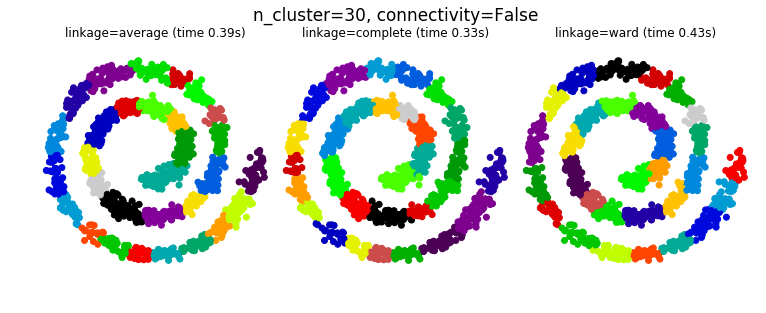

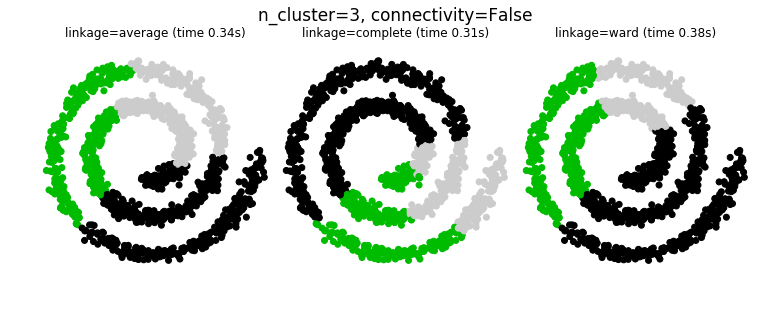

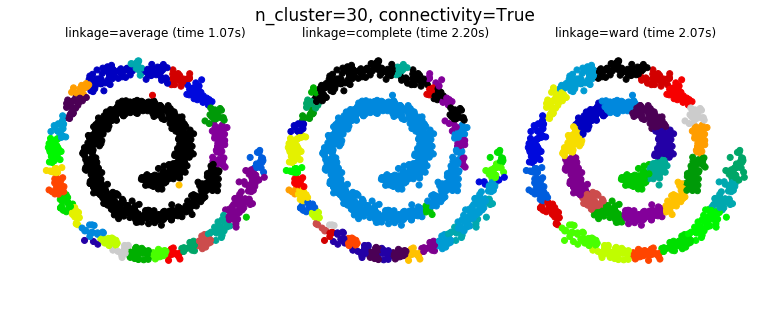

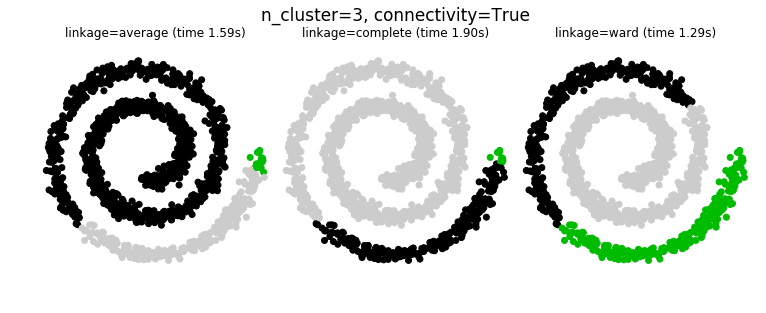

In [39]:
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

#generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data

knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

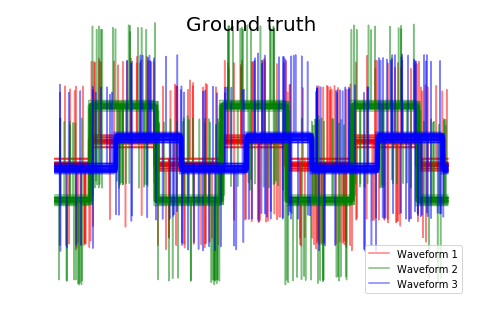

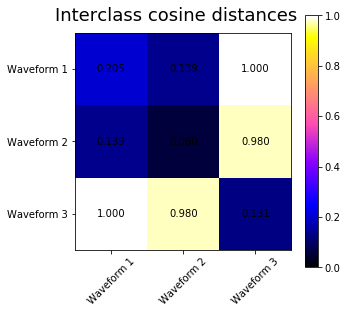

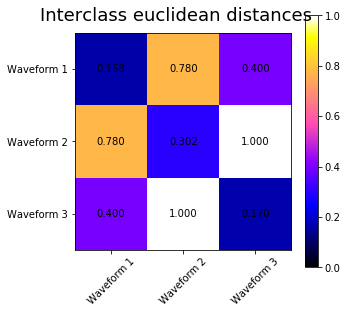

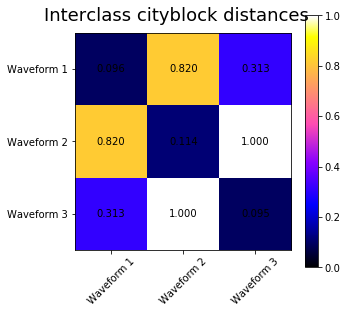

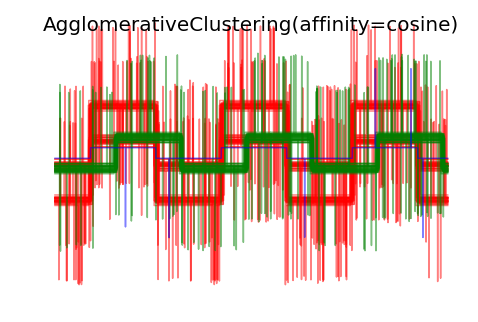

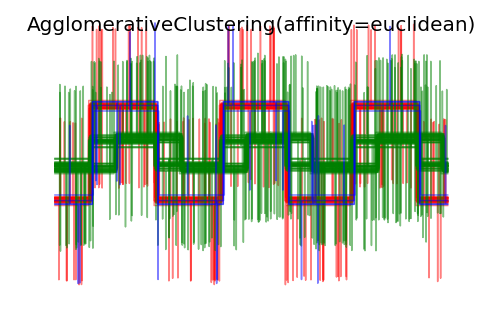

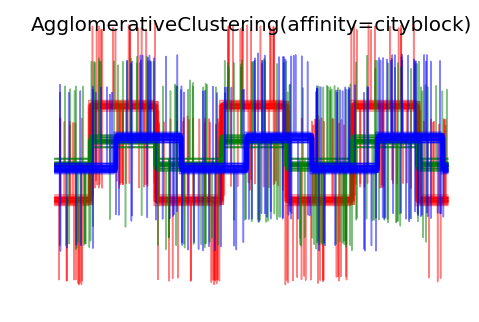

In [41]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

#generate waveform data
n_features = 2000
t = np.pi * np.linspace(0,1,n_features)

def sqr(x):
    return np.sign(np.cos(x))

X = list()
y = list()
for i, (phi, a) in enumerate([(.5, .15), (.5, .6), (.3, .2)]):
    for _ in range(30):
        phase_noise = .01 * np.random.normal()
        amplitude_noise = .04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)
        # Make the noise sparse
        additional_noise[np.abs(additional_noise) < .997] = 0

        X.append(12 * ((a + amplitude_noise)
                 * (sqr(6 * (t + phi + phase_noise)))
                 + additional_noise))
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ('Waveform 1', 'Waveform 2', 'Waveform 3')

# Plot the ground-truth labelling
plt.figure()
plt.axes([0, 0, 1, 1])
for l, c, n in zip(range(n_clusters), 'rgb',
                   labels):
    lines = plt.plot(X[y == l].T, c=c, alpha=.5)
    lines[0].set_label(n)

plt.legend(loc='best')

plt.axis('tight')
plt.axis('off')
plt.suptitle("Ground truth", size=20)


# Plot the distances
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(X[y == i], X[y == j],
                                                metric=metric).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            plt.text(i, j, '%5.3f' % avg_dist[i, j],
                     verticalalignment='center',
                     horizontalalignment='center')

    plt.imshow(avg_dist, interpolation='nearest', cmap=plt.cm.gnuplot2,
               vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18)
    plt.tight_layout()


# Plot clustering results
for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(n_clusters=n_clusters,
                                    linkage="average", affinity=metric)
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
    plt.axis('tight')
    plt.axis('off')
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)


plt.show()

DBSCAN

Estimated number of clusters: 3
Homogeneity: 0.953
Completeness: 0.883
V-measure : 0.917
Adjusted Rand Index :0.952
Adjusted Mutual Information : 0.883
Silhouette Coefficient : 0.626


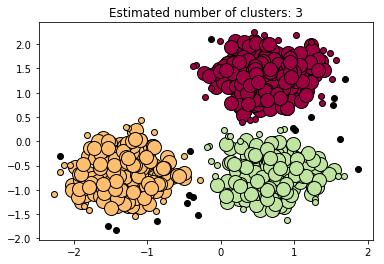

In [3]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate sample data
centers = [[1,1],[-1,-1],[1,-1]]
X,labels_true = make_blobs(n_samples=750,centers=centers,cluster_std=0.4,
                          random_state=0)
X = StandardScaler().fit_transform(X)

# compute DBSCAN
db = DBSCAN(eps=0.3,min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_,dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# number of clusters in labels ,ignore noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print('Homogeneity: %.3f' % metrics.homogeneity_score(labels_true,labels))
print('Completeness: %.3f' % metrics.completeness_score(labels_true,labels))
print('V-measure : %.3f' % metrics.v_measure_score(labels_true,labels))
print('Adjusted Rand Index :%.3f' % metrics.adjusted_rand_score(labels_true,labels))
print('Adjusted Mutual Information : %.3f' % metrics.adjusted_mutual_info_score(labels_true,labels))
print('Silhouette Coefficient : %.3f' % metrics.silhouette_score(X,labels))

# plot result
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0,1,len(unique_labels))]

for k,col in zip(unique_labels,colors):
    if k == -1 :
        # black used for noise
        col = [0,0,0,1]
    class_member_mask = (labels == k)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:,0],xy[:,1],'o',markerfacecolor=tuple(col),markeredgecolor='k',
            markersize=14)
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:,0],xy[:,1],'o',markerfacecolor=tuple(col),markeredgecolor='k',
            markersize=6)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()
        

Birch

Birch without global clustering as the final step took 16.57 seconds
n_clusters : 158
Birch with global clustering as the final step took 16.16 seconds
n_clusters : 100
Time taken to run MiniBatchKMeans 12.17 seconds


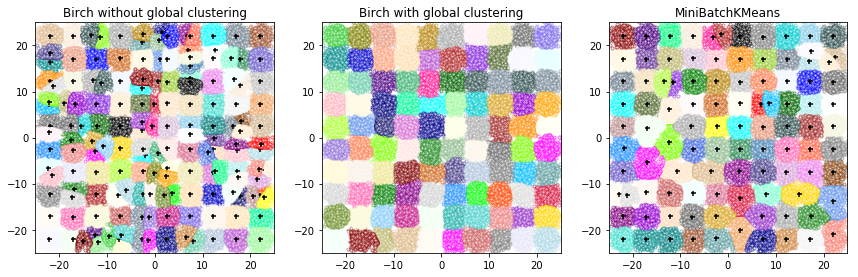

In [6]:
from itertools import cycle
from time import time
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch,MiniBatchKMeans
from sklearn.datasets import make_blobs

# generate centers for blobs so that it forms a 10 x 10 grid
xx = np.linspace(-22,22,10)
yy = np.linspace(-22,22,10)
xx,yy = np.meshgrid(xx,yy)
n_centers = np.hstack((np.ravel(xx)[:,np.newaxis],np.ravel(yy)[:,np.newaxis]))

# generate bolbs to do a comparison between Minibatchkmeans and birch.
X,y = make_blobs(n_samples=100000,centers=n_centers,random_state=0)

# use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(left=0.04,right=0.98,bottom=0.1,top=0.9,wspace=0.2)

# compute clustering with birch with and without the final clustering step and plots.
birch_models = [Birch(threshold=1.7,n_clusters=None),
               Birch(threshold=1.7,n_clusters=100)]
final_step = ['without global clustering','with global clustering']

for ind,(birch_model,info) in enumerate(zip(birch_models,final_step)):
    t = time()
    birch_model.fit(X)
    time_ = time() - t
    print('Birch %s as the final step took %.2f seconds' %(info,(time() -t)))
    
    # plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print('n_clusters : %d' % n_clusters)
    
    ax = fig.add_subplot(1,3,ind+1)
    for this_centroid, k, col in zip(centroids,range(n_clusters),colors_):
        mask = labels == k
        ax.scatter(X[mask,0],X[mask,1],c='w',edgecolor=col,marker='.',alpha=0.5)
        if birch_model.n_clusters is None:
            ax.scatter(this_centroid[0],this_centroid[1],marker='+',c='k',s=25)
    ax.set_ylim([-25,25])
    ax.set_xlim([-25,25])
    ax.set_autoscaley_on(False)
    ax.set_title('Birch %s' % info)
    
# compute clustering with MiniBatchKMeans
mbk = MiniBatchKMeans(init='k-means++',n_clusters=100,batch_size=100,n_init=10,
                     max_no_improvement=10,verbose=0,random_state=0)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
print('Time taken to run MiniBatchKMeans %.2f seconds' % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(133)
for this_centroid, k, col in zip(mbk.cluster_centers_,range(n_clusters),colors_):
    mask = mbk.labels_ == k
    ax.scatter(X[mask,0],X[mask,1],marker='.',c='w',edgecolor=col,alpha=0.5)
    ax.scatter(this_centroid[0],this_centroid[1],marker='+',c='k',s=25)
ax.set_xlim([-25,25])
ax.set_ylim([-25,25])
ax.set_title('MiniBatchKMeans')
ax.set_autoscaley_on(False)
plt.show()
        
    


In [9]:
from sklearn import metrics
labels_true = [0,0,0,1,1,1]
labels_pred = [0,0,1,1,2,2]

metrics.adjusted_rand_score(labels_true,labels_pred)

0.24242424242424246

In [10]:
labels_pred = [1,1,0,0,3,3]
metrics.adjusted_rand_score(labels_true,labels_pred)

0.24242424242424246

In [11]:
labels_true = [0, 1, 2, 0, 3, 4, 5, 1]
labels_pred = [1, 1, 0, 0, 2, 2, 2, 2]
metrics.adjusted_rand_score(labels_true, labels_pred)  


-0.12903225806451613

Computing adjusted_rand_score for 10 values of n_clusters and n_samples=100
Done in 0.137s
Computing v_measure_score for 10 values of n_clusters and n_samples=100
Done in 0.210s
Computing adjusted_mutual_info_score for 10 values of n_clusters and n_samples=100
Done in 1.546s
Computing mutual_info_score for 10 values of n_clusters and n_samples=100
Done in 0.182s
Computing adjusted_rand_score for 10 values of n_clusters and n_samples=1000
Done in  0.277s 
Computing v_measure_score for 10 values of n_clusters and n_samples=1000
Done in  0.328s 
Computing adjusted_mutual_info_score for 10 values of n_clusters and n_samples=1000
Done in  0.819s 
Computing mutual_info_score for 10 values of n_clusters and n_samples=1000
Done in  0.147s 


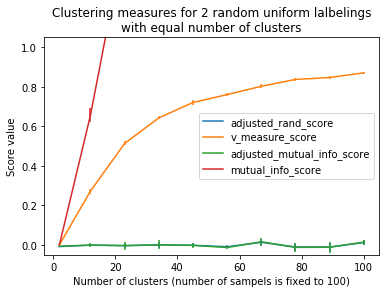

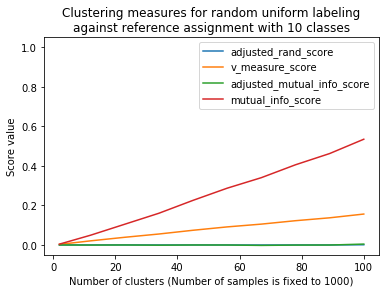

In [16]:
from time import time 
from sklearn import metrics

def uniform_labelings_scores(score_func,n_samples,n_clusters_range,
                            fixed_n_classes=None,n_runs=5,seed=42):
    '''Compute score for 2 random uniform cluster labelings. '''
    random_labels = np.random.RandomState(seed).randint
    scores = np.zeros((len(n_clusters_range),n_runs))
    
    if fixed_n_classes is not None:
        labels_a = random_labels(low=0,high=fixed_n_classes,size=n_samples)
    for i, k in enumerate(n_clusters_range):
        for j in range(n_runs):
            if fixed_n_classes is None:
                labels_a = random_labels(low=0,high=k,size=n_samples)
            labels_b = random_labels(low=0,high=k,size=n_samples)
            scores[i,j] = score_func(labels_a,labels_b)
    return scores

score_funcs = [
    metrics.adjusted_rand_score,
    metrics.v_measure_score,
    metrics.adjusted_mutual_info_score,
    metrics.mutual_info_score
]
# 2 independent random clusterings with equal cluster number
n_samples = 100
n_clusters_range = np.linspace(2,n_samples,10).astype(np.int)

plt.figure(1)
plots = []
names = []
for score_func in score_funcs:
    print('Computing %s for %d values of n_clusters and n_samples=%d'
         %(score_func.__name__,len(n_clusters_range),n_samples))
    t0 = time()
    scores = uniform_labelings_scores(score_func,n_samples,n_clusters_range)
    print('Done in %.3fs' % (time()-t0))
    plots.append(plt.errorbar(
        n_clusters_range,np.median(scores,axis=1),scores.std(axis=1))[0])
    names.append(score_func.__name__)
    
plt.title('Clustering measures for 2 random uniform lalbelings\n'
         'with equal number of clusters')
plt.xlabel('Number of clusters (number of sampels is fixed to %d)' % n_samples)
plt.ylabel('Score value')
plt.legend(plots,names)
plt.ylim(ymin=-0.05,ymax=1.05)

# random labeling with varying n_clusters against ground class labels with fixed nember of clusters 
n_samples = 1000
n_clusters_range = np.linspace(2,100,10).astype(np.int)
n_classes = 10

plt.figure(2)
plots = []
names = []

for score_func in score_funcs:
    print('Computing %s for %d values of n_clusters and n_samples=%d'
         %(score_func.__name__,len(n_clusters_range),n_samples))
    t0 = time()
    scores = uniform_labelings_scores(score_func,n_samples,n_clusters_range,
                                     fixed_n_classes=n_classes)
    print('Done in % .3fs ' % (time()-t0))
    plots.append(plt.errorbar(
        n_clusters_range,scores.mean(axis=1))[0])
    names.append(score_func.__name__)
    
plt.title('Clustering measures for random uniform labeling\n'
         'against reference assignment with %d classes' % n_classes)
plt.xlabel('Number of clusters (Number of samples is fixed to %d)' % n_samples)
plt.ylabel('Score value')
plt.ylim(ymin=-0.05,ymax=1.05)
plt.legend(plots,names)
plt.show()

    

In [17]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

metrics.adjusted_mutual_info_score(labels_true, labels_pred)  

0.2250422831983088

In [18]:
labels_pred = [1, 1, 0, 0, 3, 3]
metrics.adjusted_mutual_info_score(labels_true, labels_pred)  

0.2250422831983088

All, mutual_info_score, adjusted_mutual_info_score and normalized_mutual_info_score are symmetric: swapping the argument does not change the score. Thus they can be used as a consensus measure:

In [19]:
metrics.adjusted_mutual_info_score(labels_pred,labels_true)

0.2250422831983088

In [20]:
labels_pred = labels_true[:]
metrics.adjusted_mutual_info_score(labels_true,labels_pred)

1.0

In [21]:
metrics.normalized_mutual_info_score(labels_true,labels_pred)

1.0

In [22]:
metrics.mutual_info_score(labels_true,labels_pred)

0.69314718055994518

In [23]:
from sklearn import metrics
labels_true = [0,0,0,1,1,1]
labels_pred = [0,0,1,1,2,2]

metrics.homogeneity_score(labels_true,labels_pred)


0.66666666666666685

In [24]:
metrics.completeness_score(labels_true,labels_pred)

0.420619835714305

In [25]:
metrics.v_measure_score(labels_true,labels_pred)

0.51580374297938891

In [26]:
metrics.homogeneity_completeness_v_measure(labels_true,labels_pred)

(0.66666666666666685, 0.420619835714305, 0.51580374297938891)

In [27]:
labels_pred = [0, 0, 0, 1, 2, 2]
metrics.homogeneity_completeness_v_measure(labels_true, labels_pred)
                                                     

(1.0, 0.68533147896158653, 0.81328983350367623)

homogeneity_score(a, b) == completeness_score(b, a)

In [28]:
from sklearn import metrics
labels_true = [0,0,0,1,1,1]
labels_pred = [0,0,1,1,2,2]


In [29]:
metrics.fowlkes_mallows_score(labels_true,labels_pred)

0.47140452079103173

In [30]:
labels_pred = [1, 1, 0, 0, 3, 3]

metrics.fowlkes_mallows_score(labels_true, labels_pred)  


0.47140452079103173

In [31]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
dataset = datasets.load_iris()
X ,y = dataset.data,dataset.target


In [32]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=3,random_state=1).fit(X,y)
labels = kmeans_model.labels_
metrics.silhouette_score(X,labels,metric='euclidean')

0.5525919445309031

In [35]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.cluster import KMeans
iris = datasets.load_iris()
X,y = iris.data,iris.target
kmeans_model = KMeans(n_clusters=3,random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.calinski_harabaz_score(X,labels)

560.39992424664024

# Biclustering

In [37]:
data = np.arange(100).reshape(10,10)
rows = np.array([0,2,3])[:,np.newaxis]
columns = np.array([1,2])
data[rows,columns]

array([[ 1,  2],
       [21, 22],
       [31, 32]])

In [39]:
data[[0,2,3],[1,2,3]]

array([ 1, 22, 33])

In [41]:
data[[[0],[2],[3]],[1,2]]

array([[ 1,  2],
       [21, 22],
       [31, 32]])

In [43]:
data.ix[[1,2,3],[1,2]]

AttributeError: 'numpy.ndarray' object has no attribute 'ix'

consensus score: 1.000


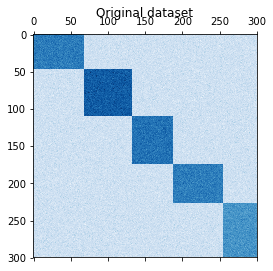

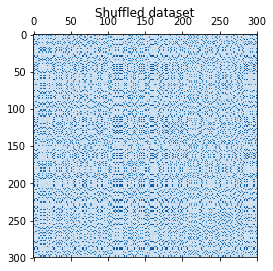

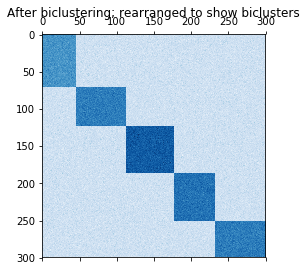

In [47]:
from sklearn.datasets import make_biclusters
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.datasets import samples_generator as sg
from sklearn.metrics import consensus_score

data,rows,columns = make_biclusters(shape=(300,300),n_clusters=5,noise=5,
                                   shuffle=False,random_state=0)
plt.matshow(data,cmap=plt.cm.Blues)
plt.title('Original dataset')

data,row_idx,col_idx = sg._shuffle(data,random_state=0)
plt.matshow(data,cmap=plt.cm.Blues)
plt.title('Shuffled dataset')

model = SpectralCoclustering(n_clusters=5,random_state=0)
model.fit(data)
score = consensus_score(model.biclusters_,(rows[:,row_idx],columns[:,col_idx]))
print('consensus score: {:.3f}'.format(score))

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:,np.argsort(model.column_labels_)]

plt.matshow(fit_data,cmap=plt.cm.Blues)
plt.title('After biclustering; rearranged to show biclusters')

plt.show()

consensus score: 1.0


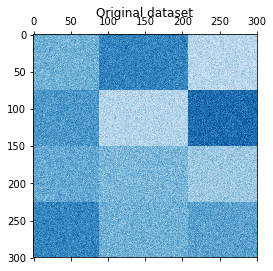

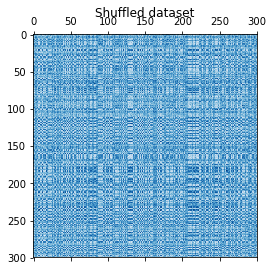

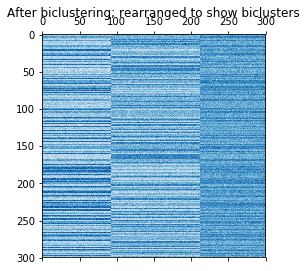

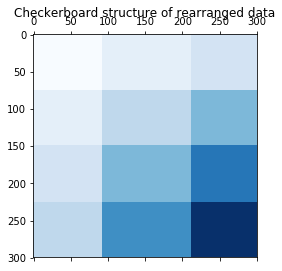

In [50]:
from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

n_clusters = (4,3)
data,rows,columns = make_checkerboard(shape=(300,300),n_clusters=n_clusters,
                                     noise=10,shuffle=False,random_state=0)
plt.matshow(data,cmap=plt.cm.Blues)
plt.title('Original dataset')

data,row_idx,col_idx = sg._shuffle(data,random_state=0)
plt.matshow(data,cmap=plt.cm.Blues)
plt.title('Shuffled dataset')

model = SpectralBiclustering(n_clusters=n_clusters,method='log',random_state=0)
model.fit(data)
score = consensus_score(model.biclusters_,(rows[:,row_idx],columns[:,col_idx]))

print('consensus score: {:.1f}'.format(score))

fit_data = data[np.argsort(model.row_labels_)]
fit_data = data[:,np.argsort(model.column_labels_)]

plt.matshow(fit_data,cmap=plt.cm.Blues)
plt.title('After biclustering; rearranged to show biclusters')

plt.matshow(np.outer(np.sort(model.row_labels_) + 1,
                     np.sort(model.column_labels_) + 1),cmap=plt.cm.Blues)
plt.title('Checkerboard structure of rearranged data')

plt.show()

# Decomposing signals in components

PCA

Explained variance ratio (first two components): [ 0.92461621  0.05301557]


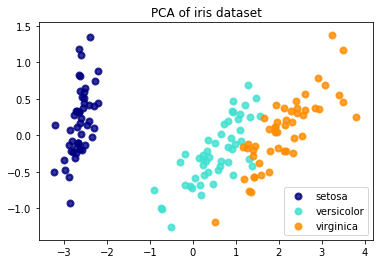

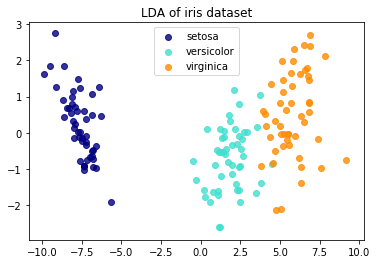

In [56]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X,y = iris.data,iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X,y).transform(X)

print('Explained variance ratio (first two components): %s'% str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy','turquoise','darkorange']
lw = 2
for color,i,target_name in zip(colors,[0,1,2],target_names):
    plt.scatter(X_r[y==i,0],X_r[y==i,1],c=color,alpha=.8,lw=lw,label=target_name)
plt.legend(loc='best',shadow=False,scatterpoints=1)
plt.title('PCA of iris dataset')

plt.figure()
for color,i,target_name in zip(colors,[0,1,2],target_names):
    plt.scatter(X_r2[y==i,0],X_r2[y==i,1],alpha=0.8,c=color,label=target_name)
plt.legend(loc='best',shadow=False,scatterpoints=1)
plt.title('LDA of iris dataset')
plt.show()

best n_components by PCA cv = 10
best n_components by FatorAnalysis cv = 10
best n_components by PCA MLE = 10
best n_components by PCA cv = 40
best n_components by FatorAnalysis cv = 10
best n_components by PCA MLE = 38


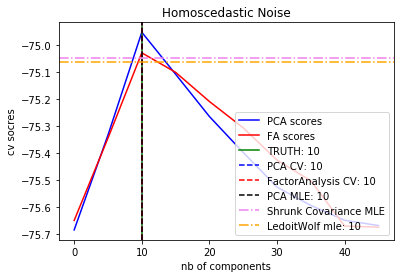

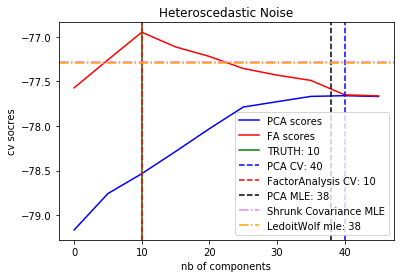

In [4]:
from scipy import linalg
from sklearn.decomposition import PCA,FactorAnalysis
from sklearn.covariance import ShrunkCovariance,LedoitWolf
from sklearn.model_selection import cross_val_score,GridSearchCV

# create the data
n_samples,n_features,rank = 1000,50,10
sigma = 1.
rng = np.random.RandomState(42)
U,_,_ = linalg.svd(rng.randn(n_features,n_features))
X = np.dot(rng.randn(n_samples,rank),U[:,:rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples,n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_hetero = X + rng.randn(n_samples,n_features) * sigmas

# fit the model
n_components = np.arange(0,n_features,5) 

def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()
    
    pca_scores,fa_scores = [],[]
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca,X)))
        fa_scores.append(np.mean(cross_val_score(fa,X)))
    return pca_scores,fa_scores

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2,0,30)
    cv = GridSearchCV(ShrunkCovariance(),{'shrinkage':shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_,X))

def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(),X))

for X ,title in [(X_homo,'Homoscedastic Noise'),
                (X_hetero,'Heteroscedastic Noise')]:
    pca_scores,fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]
    
    pca = PCA(svd_solver='full',n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_
    
    print('best n_components by PCA cv = %d' % n_components_pca)
    print('best n_components by FatorAnalysis cv = %d' % n_components_fa)
    print('best n_components by PCA MLE = %d' % n_components_pca_mle)
    
    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
    plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X),color='orange',label='LedoitWolf mle: %d' %n_components_pca_mle,ls='-.')
    plt.xlabel('nb of components')
    plt.ylabel('cv socres')
    plt.legend(loc='lower right')
    plt.title(title)
    
plt.show()
    


(150, 2)


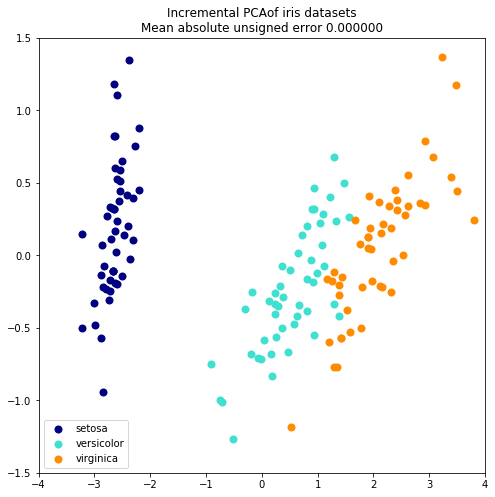

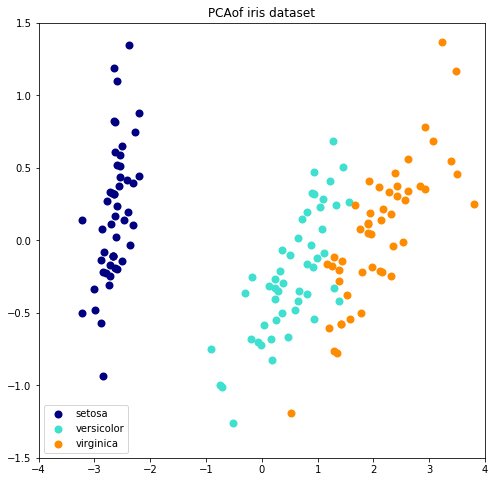

In [9]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA,IncrementalPCA

iris = load_iris()
X,y = iris.data,iris.target

n_components = 2
ipca = IncrementalPCA(n_components=n_components,batch_size=10)
X_ipca = ipca.fit_transform(X)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
colors = ['navy','turquoise','darkorange']

for X_transform,title in [(X_ipca,'Incremental PCA'),(X_pca,'PCA')]:
    plt.figure(figsize=(8,8))
    for color,i,target_name in zip(colors,[0,1,2],iris.target_names):
        plt.scatter(X_transform[y==i,0],X_transform[y==i,1],color=color,
                    lw=2,label=target_name)
    if 'Incremental' in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_pca)).mean()
        plt.title(title+'of iris datasets\nMean absolute unsigned error %.6f' %err)
    else:
        plt.title(title+'of iris dataset')
    plt.legend(loc='best',shadow=False,scatterpoints=1)
    plt.axis([-4,4,-1.5,1.5])
    
plt.show()
    


In [ ]:
from time import time
import logging

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# display progress logs on stdout
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(message)s')

# download tha data
lfw_people = fetch_lfw_people(data_home='E:/python_work/handson_ml/datasets',
                             min_faces_per_person=70,resize=0.4)

# introspect the images arrays to find the shapes
n_samples,h,w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('Total dataset size:')
print(target_names.shape)
print('n_samples: %d' %n_samples)
print('n_features: %d' %n_features)
print('n_classes: %d' %n_classes)

# split into a training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

n_components = 150

print('Extracting the top %d eigenfaces from %d faces'
     %(n_components,X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components,svd_solver='randomized',whiten=True).fit(X_train)
print('done in %.3fs' % (time() - t0))

eigenfaces = pca.components_.reshape((n_components,h,w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

2017-11-11 16:15:05,139 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2017-11-11 16:15:12,883 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2017-11-11 16:15:19,121 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2017-11-11 16:15:30,746 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.823s
Extracting the top 6 Non-negative components - NMF...
done in 1.162s
Extracting the top 6 Independent components - FastICA...
done in 1.932s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 4.532s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 3.364s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.600s
Extracting the top 6 Factor Analysis components - FA...


E:\anaconda\anaconda\lib\site-packages\sklearn\decomposition\factor_analysis.py:226: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


done in 0.784s


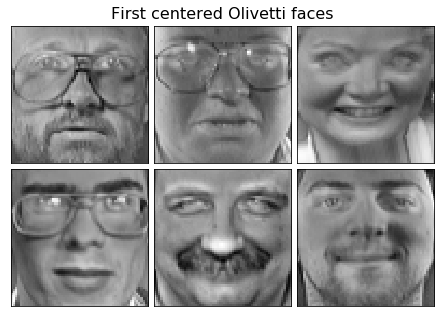

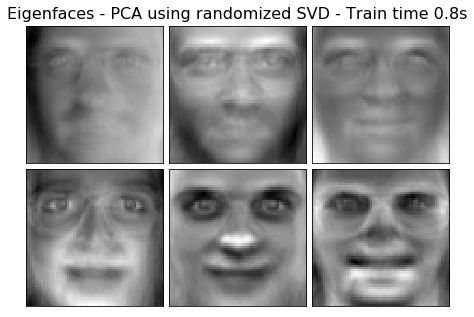

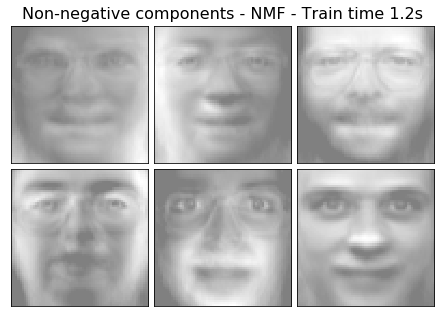

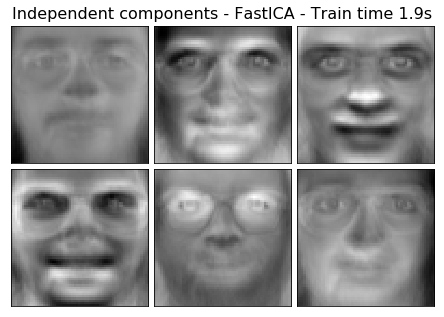

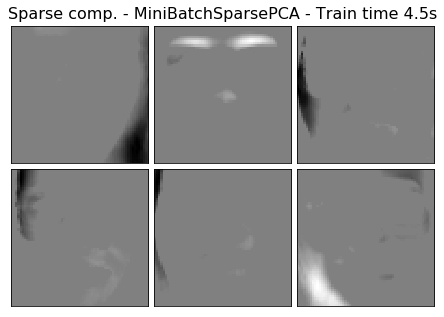

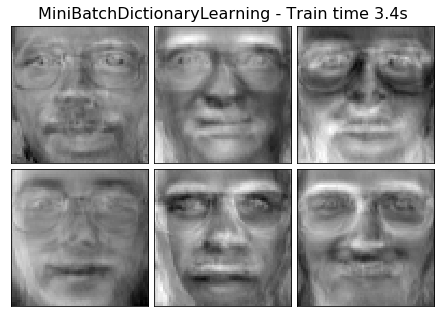

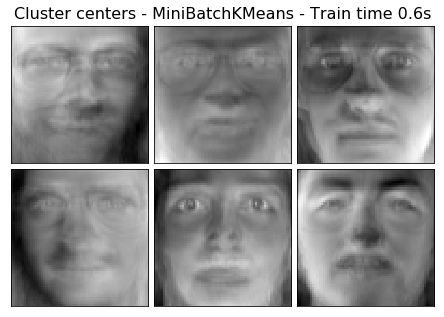

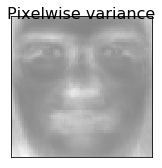

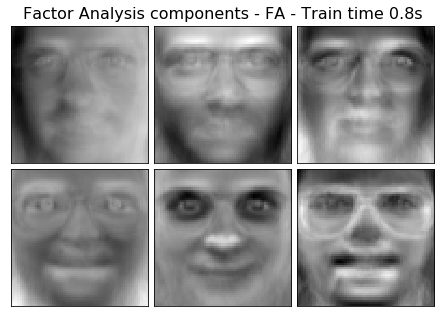

In [2]:
import logging
from time import time
from numpy.random import RandomState

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(data_home='E:/python_work/handson_ml/datasets',shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

In [3]:
 faces.shape

(400, 4096)

In [5]:
faces_centered.shape

(400, 4096)

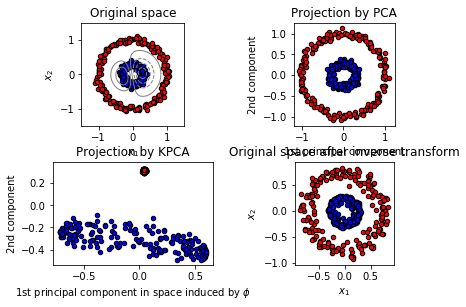

In [10]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X,y = make_circles(n_samples=400,factor=.3,noise=.05)

kpca = KernelPCA(kernel='rbf',fit_inverse_transform=True,gamma=10)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)

pca = PCA()
X_pca = pca.fit_transform(X)

# plot  results
plt.figure()
plt.subplot(2,2,1,aspect='equal')
plt.title('Original space')
reds = y==0
blues = y==1

plt.scatter(X[reds,0],X[reds,1],c='red',s=20,edgecolor='k')
plt.scatter(X[blues,0],X[blues,1],c='blue',s=20,edgecolor='k')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

X1,X2 = np.meshgrid(np.linspace(-1.5,1.5,50),np.linspace(-1.5,1.5,50))
#X_grid = np.c_[np.ravel(X1),np.ravel(X2)]
#Z_grid = kpca.transform(X_grid)[:,1].reshape(X1.shape)
X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")

plt.subplot(2, 2, 3, aspect='equal')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Projection by KPCA")
plt.xlabel("1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.subplot(2, 2, 4, aspect='equal')
plt.scatter(X_back[reds, 0], X_back[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X_back[blues, 0], X_back[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.subplots_adjust(0.02, 0.10, 0.98, 0.94, 0.04, 0.35)

plt.show()

In [14]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans,MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

# display progress lags on stdout
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(messages)s')

# parse commmandline arguments
op = OptionParser()
op.add_option('--lsa',dest='n_components',type='int',
             help='Preprocess documents with latent semantic analysis.')
op.add_option('--no-minibatch',action='store_false',dest='minibatch',default=True,
             help='Use ordinary k-means algorithm (in batch mode).')
op.add_option("--no-idf",action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()

def is_interactice():
    return not hasattr(sys.modules['__main__'],'__file__')

argv = [] if is_interactice() else sys.argv[1:]
(opts,args) = op.parse_args(argv)
if len(args) > 0:
    op.error('this script takes no arguments.')
    sys.exit(1)
    

# load same categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space'
]

print('Loading 20 newsgroups datasets for categories:')
print(categories)

dataset = fetch_20newsgroups(data_home='E:/python_work/handson_ml/datasets',
                              subset='all',categories=categories,
                             shuffle=True,random_state=42)

print('%d documents' % len(dataset.data))
print('%d categories' % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print('Extracting features from the training dataset using a sparse vectorizer.')
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        hasher = HashingVectorizer(n_features=opts.n_features,stop_words='english',
                                  alternate_sign=False,norm=None,binary=False)
        vectorizer = make_pipeline(hasher,TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features-opts.n_features,
                                      stop_words='english',
                                      alternate_sign=False,norm='l2',
                                      binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=0.5,max_features=opts.n_features,
                                min_df=2,stop_words='english',
                                use_idf = opts.use_idf)
    
X  = vectorizer.fit_transform(dataset.data)

print('done in %fs' % (time() - t0))
print('n_samples : %d,n_features: %d'% X.shape)
print()

if opts.n_components:
    print('Performing dimensionality reduction using LSA')
    t0 = time()
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svc,normalizer)
    
    X = lsa.fit_transform(X)
    
    print('done in %fs' % (time() - t0))
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print('Explained variance of the SVD step: {}%'.format(int(explained_variance * 100)))
    print()
    
# Done tha actual clustering
if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k,init='k-means++',n_init=1,
                        init_size=1000,batch_size=1000,verbose=opts.verbose)

else:
    km = KMeans(n_clusters=ture_k,init='k-means++',max_iter=100,n_init=1,
               verbose=opts.verbose)
print('Clustering sparse data with %s' %km)
t0 = time()
km.fit(X)
print('done in %.3fs' %(time()-t0))
print()

print('Homogeneity: %.3f' % metrics.homogeneity_score(labels,km.labels_))
print('Completeness: %.3f' % metrics.completeness_score(labels,km.labels_))
print('V-measure: %.3f' % metrics.v_measure_score(labels,km.labels_))
print('Adjusted Rand-index: %.3f' % metrics.adjusted_rand_score(labels,km.labels_))
print('Silhouette Coefficient: %.3f' % metrics.silhouette_score(X,km.labels_,sample_size=1000))
print()

if not opts.use_hashing:
    print('Top terms per cluster:')
    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:,::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:,::-1]
        
    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print('Cluster %d:' %i,end='')
        for ind in order_centroids[i,:10]:
            print('%s' % terms[ind],end='')
        print()
        


Automatically created module for IPython interactive environment
Usage: __main__.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.
Loading 20 newsgroups datasets for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer.
done in 3.628207s
n_samples : 3387,n_features: 10000

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=T

E:\anaconda\anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


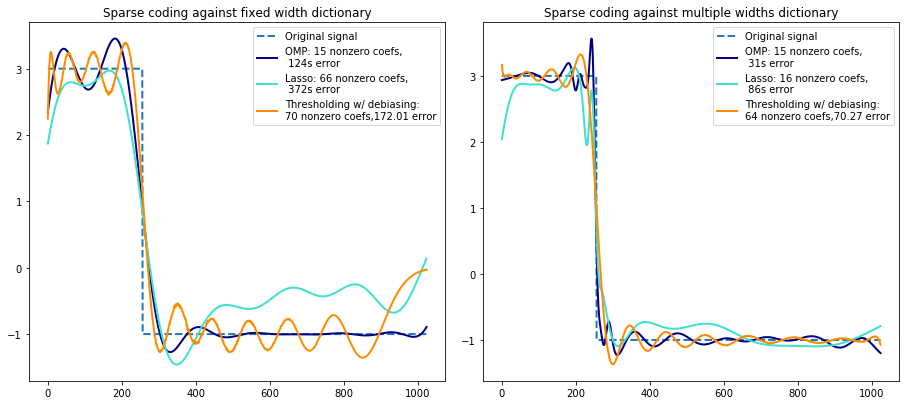

In [20]:
from sklearn.decomposition import SparseCoder

def ricker_function(resolution,center,width):
    x = np.linspace(0,resolution-1,resolution)
    x = ((2 / ((np.sqrt(3 * width) * np.pi **1 / 4)))
         * (1 - ((x - center) ** 2 / width ** 2))
         * np.exp((-(x - center) ** 2) / (2 * width ** 2)))
    return x

def ricker_matrix(width,resolution,n_components):
    centers = np.linspace(0,resolution-1,n_components)
    D = np.empty((n_components,resolution))
    for i,center in enumerate(centers):
        D[i] = ricker_function(resolution,center,width)
    D /= np.sqrt(np.sum(D ** 2 ,axis=1))[:,np.newaxis]
    return D

resolution = 1024
subsampling = 3
width = 100
n_components = resolution // subsampling

# compute a wavelet dictionary
D_fixed = ricker_matrix(width=width,resolution=resolution,
                       n_components=n_components)
D_multi = np.r_[tuple(ricker_matrix(width=w,resolution=resolution,
                                   n_components=n_components // 5)
                     for w in (10,50,100,500,1000))]
# generate a signal 
y = np.linspace(0,resolution-1,resolution)
first_quarter = y < resolution / 4
y[first_quarter] = 3
y[np.logical_not(first_quarter)] = -1

estimators = [('OMP','omp',None,15,'navy'),
             ('Lasso','lasso_cd',2,None,'turquoise')]
lw = 2

plt.figure(figsize=(13,6))
for subplot,(D,title) in enumerate(zip((D_fixed,D_multi),
                                   ('fixed width','multiple widths'))):
    plt.subplot(1,2,subplot+1)
    plt.title('Sparse coding against %s dictionary' % title)
    plt.plot(y,lw=lw,linestyle='--',label='Original signal')
    for title ,algo,alpha,n_nonzero,color in estimators:
        coder = SparseCoder(dictionary=D,transform_n_nonzero_coefs=n_nonzero,
                           transform_alpha=alpha,transform_algorithm=algo)
        x = coder.transform(y.reshape(1,-1))
        density = len(np.flatnonzero(x))
        x = np.ravel(np.dot(x,D))
        squared_error = np.sum((y-x)**2)
        plt.plot(x,color=color,lw=lw,label='%s: %s nonzero coefs,\n %2.fs error'
                %(title,density,squared_error))
    # soft thresholding debiasing
    coder = SparseCoder(dictionary=D,transform_algorithm='threshold',transform_alpha=20)
    x = coder.transform(y.reshape(1,-1))
    _,idx = np.where(x != 0)
    x[0,idx],_,_,_ = np.linalg.lstsq(D[idx,:].T,y)
    x = np.ravel(np.dot(x,D))
    squared_error = np.sum((y-x)**2)
    plt.plot(x,color='darkorange',lw=lw,label='Thresholding w/ debiasing:\n%d nonzero coefs,%.2f error'
            %(len(idx),squared_error))
    plt.axis('tight')
    plt.legend(shadow=False,loc='best')
plt.subplots_adjust(0.04,.07,.97,.90,.09,.2)
plt.show()

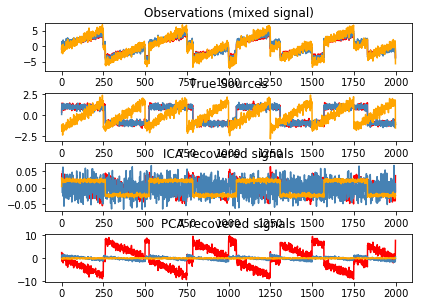

In [3]:
from scipy import signal
from sklearn.decomposition import FastICA, PCA

# generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0,8,n_samples)

s1 = np.sin(2 * time )
s2 = np.sign(np.sin(3 * time))
s3 = signal.sawtooth(2*np.pi*time)

S = np.c_[s2,s2,s3]
S += 0.2 * np.random.normal(size=S.shape)

S /= S.std(axis=0)
# Mix data
A = np.array([[1,1,1],[0.5,2,1.0],[1.5,1.,2.0]])
X = np.dot(S,A.T)

# compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)
A_ = ica.mixing_

# we can 'prove' that the ICA model applies by reverting the unmixing
assert np.allclose(X,np.dot(S_,A_.T) + ica.mean_)

# for comparison, compute pca
pca = PCA(n_components=3)
H = pca.fit_transform(X)

# plot results
plt.figure()

models = [X,S,S_,H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red','steelblue','orange']

for ii,(model,name) in enumerate(zip(models,names)):
    plt.subplot(4,1,ii+1)
    plt.title(name)
    for sig,color in zip(model.T,colors):
        plt.plot(sig,color=color)
plt.subplots_adjust(0.09,0.04,0.94,0.94,0.26,0.46)
plt.show()



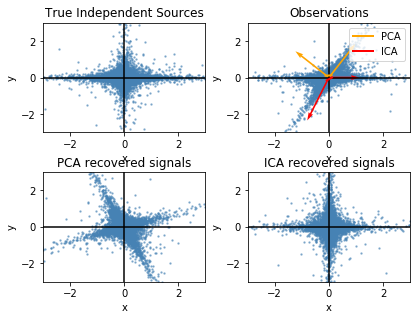

In [6]:
from sklearn.decomposition import PCA, FastICA

# generate sample data
rng = np.random.RandomState(42)
S = rng.standard_t(1.5,size=(20000,2))
S[:,0] *= 2.

# mix data
A = np.array([[1,1],[0,2]])
X = np.dot(S,A.T)

pca = PCA()
S_pca_ = pca.fit(X).transform(X)

ica = FastICA(random_state=rng)
S_ica_ = ica.fit(X).transform(X)

S_ica_ /= S_ica_.std(axis=0)

# plot results
def plot_samples(S,axis_list=None):
    plt.scatter(S[:,0],S[:,1],s=2,marker='o',color='steelblue',alpha=0.5)
    if axis_list is not None:
        colors = ['orange','red']
        for color,axis in zip(colors,axis_list):
            axis /= axis.std()
            x_axis,y_axis = axis
            plt.plot(0.1 * x_axis,0.1 * y_axis,lw=2,color=color)
            plt.quiver(0,0,x_axis,y_axis,width=0.01,scale=6,color=color)
    plt.hlines(0,-3,3)
    plt.vlines(0,-3,3)
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.figure()
plt.subplot(221)
plot_samples(S/S.std())
plt.title('True Independent Sources')

axis_list = [pca.components_.T,ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title('Observations')

plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)
plt.show()
    


In [8]:
X = np.array([[1,1],[2,1],[3,1.2],[4,1],[5,0.8],[6,1]])
from sklearn.decomposition import NMF
model = NMF(n_components=2,init='random',random_state=0)
W = model.fit_transform(X)
H = model.components_
X_new = np.array([[1,0],[1,6.1],[1,0],[1,4],[3.2,1],[0,4]])
W_new = model.transform(X_new)

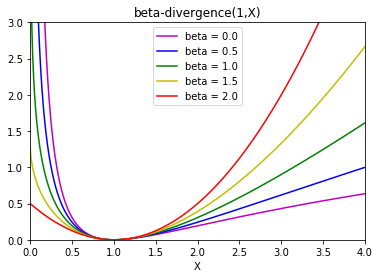

In [10]:
from sklearn.decomposition.nmf import _beta_divergence

X = np.linspace(0.001,4,1000)
y = np.zeros(X.shape)

colors= 'mbgyr'
for j,beta in enumerate((0.,0.5,1.,1.5,2.)):
    for i,xi in enumerate(X):
        y[i] = _beta_divergence(1,xi,1,beta)
    name = 'beta = %1.1f' % beta
    plt.plot(X,y,label=name,color=colors[j])
    
plt.xlabel('X')
plt.title('beta-divergence(1,X)')
plt.legend(loc=0)
plt.axis([0,4,0,3])
plt.show()

# Covariance estimation

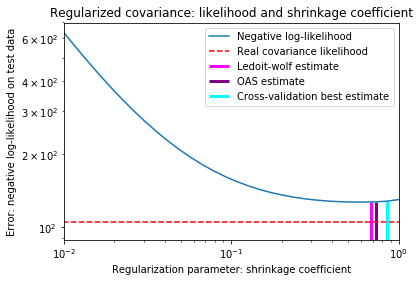

In [6]:
from scipy import linalg
from sklearn.covariance import LedoitWolf,OAS,ShrunkCovariance,\
    log_likelihood,empirical_covariance
from sklearn.model_selection import GridSearchCV

#generate sample data
n_features,n_samples = 40,20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples,n_features))
base_X_test = np.random.normal(size=(n_samples,n_features))

# color samples
coloring_matrix = np.random.normal(size=(n_features,n_features))
X_train = np.dot(base_X_train,coloring_matrix)
X_test = np.dot(base_X_test,coloring_matrix)

# compute the likelihood on test data

# spanning a range of possible shrinkage coefficient values
shrinkages = np.logspace(-2,0,30)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# under the ground-truth model
real_cov = np.dot(coloring_matrix.T,coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov,linalg.inv(real_cov))

#compute different approaches to setting the parameter

# gridsearch for an optimal shrinkage coefficient
tuned_parameters = [{'shrinkage':shrinkages}]
cv = GridSearchCV(ShrunkCovariance(),tuned_parameters)
cv.fit(X_train)

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

# OAS coefficient estimate
oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

# plot results
fig = plt.figure()
plt.title('Regularized covariance: likelihood and shrinkage coefficient')
plt.xlabel('Regularization parameter: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')
#range shrnkage curve
plt.loglog(shrinkages,negative_logliks,label='Negative log-likelihood')

plt.plot(plt.xlim(),2 * [loglik_real],'--r',label='Real covariance likelihood')

# adjust view
lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6. * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10. * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]

# lw likelihood
plt.vlines(lw.shrinkage_,ymin,-loglik_lw,color='magenta',lw=3,label='Ledoit-wolf estimate')
#OAS  likelihood
plt.vlines(oa.shrinkage_,ymin,-loglik_oa,color='purple',lw=3,label='OAS estimate')
# best cv estimator likelihood
plt.vlines(cv.best_estimator_.shrinkage,ymin,-cv.best_estimator_.score(X_test),
          color='cyan',lw=3,label='Cross-validation best estimate')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.legend()
plt.show()

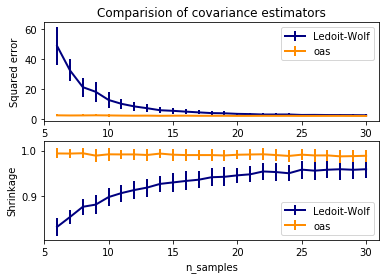

In [4]:
from scipy.linalg import toeplitz,cholesky
from sklearn.covariance import LedoitWolf,OAS

np.random.seed(0)

n_features = 100
# simulation covariance matrix 
r = 0.1
real_cov = toeplitz(r **  np.arange(n_features))
coloring_matrix = cholesky(real_cov)

n_samples_range = np.arange(6,31,1)
repeat = 100
lw_mse = np.zeros((n_samples_range.size,repeat))
oa_mse = np.zeros((n_samples_range.size,repeat))
lw_shrinkage = np.zeros((n_samples_range.size,repeat))
oa_shrinkage = np.zeros((n_samples_range.size,repeat))

for i,n_samples in enumerate(n_samples_range):
    for j in range(repeat):
        X = np.dot(
            np.random.normal(size=(n_samples,n_features)),coloring_matrix.T)
        lw = LedoitWolf(store_precision=False,assume_centered=True)
        lw.fit(X)
        lw_mse[i,j] = lw.error_norm(real_cov,scaling=False)
        lw_shrinkage[i,j] = lw.shrinkage_
        
        oa = OAS(store_precision=False,assume_centered=True)
        oa.fit(X)
        oa_mse[i,j] = oa.error_norm(real_cov,scaling=False)
        oa_shrinkage[i,j] = oa.shrinkage_
        
# plot mse
plt.subplot(211)
plt.errorbar(n_samples_range,lw_mse.mean(1),yerr=lw_mse.std(1),
             label='Ledoit-Wolf',color='navy',lw=2)
plt.errorbar(n_samples_range,oa_mse.mean(1),yerr=oa_mse.std(1),
             label='oas',color='darkorange',lw=2)
plt.ylabel('Squared error')
plt.legend(loc='upper right')
plt.title('Comparision of covariance estimators')
plt.xlim(5,31)
# plot shrinkage coefficient
plt.subplot(212)
plt.errorbar(n_samples_range,lw_shrinkage.mean(1),yerr=lw_shrinkage.std(1),
             label='Ledoit-Wolf',color='navy',lw=2)
plt.errorbar(n_samples_range,oa_shrinkage.mean(1),yerr=oa_shrinkage.std(1),
             label='oas',color='darkorange',lw=2)
plt.xlabel('n_samples')
plt.ylabel('Shrinkage')
plt.legend(loc='lower right')
plt.ylim(plt.ylim()[0],1. + (plt.ylim()[1] - plt.ylim()[0])/ 10.)
plt.xlim(5,31)

plt.show()

E:\anaconda\anaconda\lib\site-packages\ipykernel\__main__.py:58: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


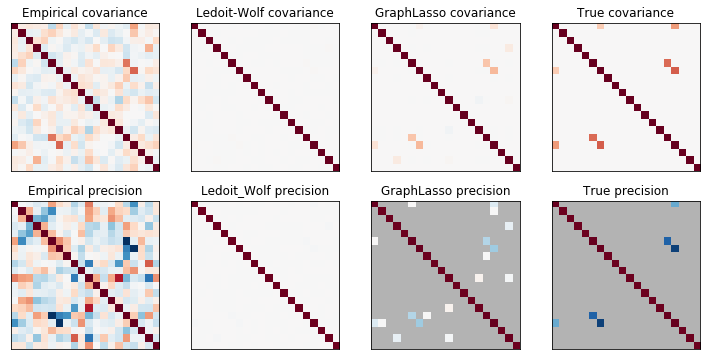

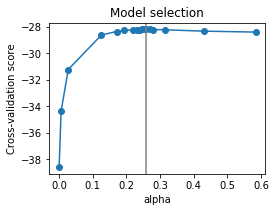

In [10]:
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphLassoCV,ledoit_wolf

# generate the data
n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features,alpha=.98,smallest_coef=.4,
                             largest_coef=.7,random_state=prng)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:,np.newaxis]
prec *= d
prec *= d[:,np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features),cov,size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# estimate the covariance
emp_cov = np.dot(X.T,X) / n_samples

model = GraphLassoCV()
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

lw_cov_ ,_ = ledoit_wolf(X)
lw_prec_ = linalg.inv(lw_cov_)

# plot the results
plt.figure(figsize=(10,6))
plt.subplots_adjust(left=0.02,right=0.98)
# plot the covariance
covs = [('Empirical',emp_cov),('Ledoit-Wolf',lw_cov_),
       ('GraphLasso',cov_),('True',cov)]
vmax = cov.max()
for i,(name,this_cov) in enumerate(covs):
    plt.subplot(2,4,i+1)
    plt.imshow(this_cov,interpolation='nearest',vmin=-vmax,vmax=vmax,
              cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)
# plot the precisions
precs = [('Empirical', linalg.inv(emp_cov)),('Ledoit_Wolf',lw_prec_),
        ('GraphLasso',prec_),('True',prec)]
vmax = .9 * prec_.max()
for i,(name,this_prec) in enumerate(precs):
    ax = plt.subplot(2,4,i+5)
    plt.imshow(np.ma.masked_equal(this_prec,0),interpolation='nearest',
              vmin=-vmax,vmax=vmax,cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s precision' % name)
    ax.set_axis_bgcolor('.7')
    
# plot the model selection metric
plt.figure(figsize=(4,3))
plt.axes([.2,.15,.75,.7])
plt.plot(model.cv_alphas_,np.mean(model.grid_scores_,axis=1),'o-')
plt.axvline(model.alpha_,color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

plt.show()


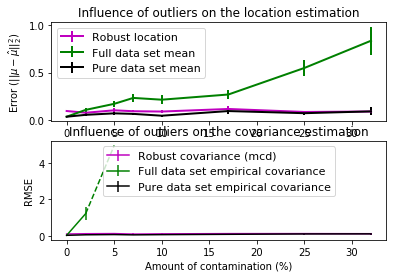

In [16]:
import matplotlib.font_manager
from sklearn.covariance import EmpiricalCovariance,MinCovDet

# emaple settings
n_samples = 80
n_features = 5
repeat = 10

range_n_outliers = np.concatenate(
    (np.linspace(0,n_samples / 8,5),
    np.linspace(n_samples / 8,n_samples /2 ,5)[1:-1])).astype(np.int)
# definition of arrays to store results
err_loc_mcd = np.zeros((range_n_outliers.size,repeat))
err_cov_mcd = np.zeros((range_n_outliers.size,repeat))
err_loc_emp_full = np.zeros((range_n_outliers.size,repeat))
err_cov_emp_full = np.zeros((range_n_outliers.size,repeat))
err_loc_emp_pure = np.zeros((range_n_outliers.size,repeat))
err_cov_emp_pure = np.zeros((range_n_outliers.size,repeat))

# computation
for i,n_outliers in enumerate(range_n_outliers):
    for j in range(repeat):
        rng = np.random.RandomState(i*j)
        # generate data
        X = rng.randn(n_samples,n_features)
        # add some outliers
        outliers_index = rng.permutation(n_samples)[:n_outliers]
        outliers_offset = 10. * (np.random.randint(2,size=(n_outliers,n_features))-0.5)
        X[outliers_index] += outliers_offset
        inliers_mask = np.ones(n_samples).astype(bool)
        inliers_mask[outliers_index] = False
        
        # fit a minimun covariance determinant robust estimator to data
        mcd = MinCovDet().fit(X)
        # compare raw robust estimates with the true location and covariance
        err_loc_mcd[i,j] = np.sum(mcd.location_ **2)
        err_cov_mcd[i,j]=mcd.error_norm(np.eye(n_features))
        # compare estimators learned from the full dataset with true parameters
        err_loc_emp_full[i,j] = np.sum(X.mean(0) **2)
        err_cov_emp_full[i,j] = EmpiricalCovariance().fit(X).error_norm(np.eye(n_features))
        
        # compute with an empirical covariance learned from a pure data set
        pure_X = X[inliers_mask]
        pure_location = pure_X.mean(0)
        pure_emp_cov = EmpiricalCovariance().fit(pure_X)
        err_loc_emp_pure[i,j] = np.sum(pure_location **2)
        err_cov_emp_pure[i,j] = pure_emp_cov.error_norm(np.eye(n_features))
# display results
font_prop = matplotlib.font_manager.FontProperties(size=11)
plt.subplot(211)
lw = 2
plt.errorbar(range_n_outliers,err_loc_mcd.mean(1),
             yerr=err_loc_mcd.std(1)/np.sqrt(repeat),
             label='Robust location',lw=lw,color='m')
plt.errorbar(range_n_outliers, err_loc_emp_full.mean(1),
             yerr=err_loc_emp_full.std(1) / np.sqrt(repeat),
             label="Full data set mean", lw=lw, color='green')
plt.errorbar(range_n_outliers, err_loc_emp_pure.mean(1),
             yerr=err_loc_emp_pure.std(1) / np.sqrt(repeat),
             label="Pure data set mean", lw=lw, color='black')
plt.title("Influence of outliers on the location estimation")
plt.ylabel(r"Error ($||\mu - \hat{\mu}||_2^2$)")
plt.legend(loc="upper left", prop=font_prop)

plt.subplot(2, 1, 2)
x_size = range_n_outliers.size
plt.errorbar(range_n_outliers, err_cov_mcd.mean(1),
             yerr=err_cov_mcd.std(1),
             label="Robust covariance (mcd)", color='m')
plt.errorbar(range_n_outliers[:(x_size // 5 + 1)],
             err_cov_emp_full.mean(1)[:(x_size // 5 + 1)],
             yerr=err_cov_emp_full.std(1)[:(x_size // 5 + 1)],
             label="Full data set empirical covariance", color='green')
plt.plot(range_n_outliers[(x_size // 5):(x_size // 2 - 1)],
         err_cov_emp_full.mean(1)[(x_size // 5):(x_size // 2 - 1)],
         color='green', ls='--')
plt.errorbar(range_n_outliers, err_cov_emp_pure.mean(1),
             yerr=err_cov_emp_pure.std(1),
             label="Pure data set empirical covariance", color='black')
plt.title("Influence of outliers on the covariance estimation")
plt.xlabel("Amount of contamination (%)")
plt.ylabel("RMSE")
plt.legend(loc="upper center", prop=font_prop)

plt.show()
        

In [17]:
err_loc_mcd.shape

(8, 10)

In [19]:
range_n_outliers.size,range_n_outliers.shape

(8, (8,))

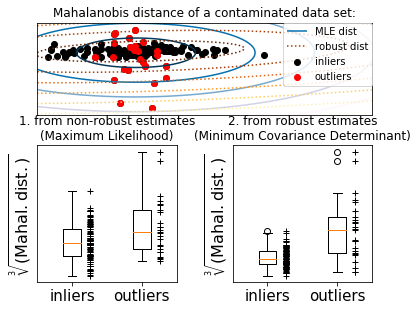

In [22]:
from sklearn.covariance import EmpiricalCovariance,MinCovDet

n_samples = 125
n_outliers = 25
n_features = 2

# generate data
gen_cov = np.eye(n_features)
gen_cov[0,0] = 2.
X = np.dot(np.random.randn(n_samples,n_features),gen_cov)
# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1,n_features),np.arange(1,n_features)] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers,n_features),outliers_cov)

# fit a minimun covariance determinant robust estimator to data
robust_cov = MinCovDet().fit(X)

# compute estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(X)

# display results
fig = plt.figure()
plt.subplots_adjust(hspace=-.1,wspace=.4,top=.95,bottom=.05)

# show data set
subfig1 = plt.subplot(3,1,1)
inlier_plot = subfig1.scatter(X[:,0],X[:,1],color='black',label='inliers')
outlier_plot = subfig1.scatter(X[:,0][-n_outliers:],X[:,1][-n_outliers:],
                              color='red',label='outliers')
subfig1.set_xlim(subfig1.get_xlim()[0],11.)
subfig1.set_title('Mahalanobis distance of a contaminated data set:')

# show contours of the distance functions
xx,yy = np.meshgrid(np.linspace(plt.xlim()[0],plt.xlim()[1],100),
                   np.linspace(plt.ylim()[0],plt.ylim()[1],100))
zz = np.c_[xx.ravel(),yy.ravel()]

mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = subfig1.contour(xx,yy,np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,ls='dashed')
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, 
                                 linestyles='dotted')
subfig1.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
                inlier_plot, outlier_plot],
               ['MLE dist', 'robust dist', 'inliers', 'outliers'],
               loc="upper right", borderaxespad=0)
plt.xticks(())
plt.yticks(())

# plot the scores for each point
emp_mahal = emp_cov.mahalanobis(X - np.mean(X,0)) ** (0.33)
subfig2 = plt.subplot(2, 2, 3)
subfig2.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
subfig2.plot(1.26 * np.ones(n_samples - n_outliers),
             emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig2.plot(2.26 * np.ones(n_outliers),
             emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig2.set_title("1. from non-robust estimates\n(Maximum Likelihood)")
plt.yticks(())

robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
subfig3 = plt.subplot(2, 2, 4)
subfig3.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
                widths=.25)
subfig3.plot(1.26 * np.ones(n_samples - n_outliers),
             robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig3.plot(2.26 * np.ones(n_outliers),
             robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig3.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig3.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig3.set_title("2. from robust estimates\n(Minimum Covariance Determinant)")
plt.yticks(())

plt.show()

# Novelty and Outlier Detection

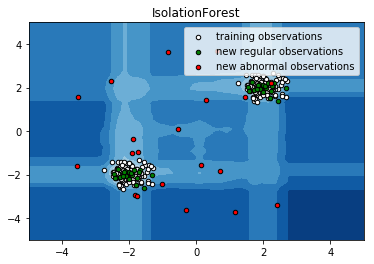

In [24]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(0)

# generate train data
X = 0.3 * rng.randn(100,2)
X_train = np.r_[X+2,X-2]
# generate some regular novel observations
X = 0.3 * rng.randn(20,2)
X_test = np.r_[X+2,X-2]
# generate some abnormal novel observations
X_outliers = rng.uniform(low=-4,high=4,size=(20,2))

# fit the model
clf = IsolationForest(max_samples=100,random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line,the samples,and the nearest vectors to the plane
xx,yy = np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))
Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title('IsolationForest')
plt.contourf(xx,yy,Z,cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:,0],X_train[:,1],c='white',s=20,edgecolor='k')
b2 = plt.scatter(X_test[:,0],X_test[:,1],c='green',s=20,edgecolor='k')
c = plt.scatter(X_outliers[:,0],X_outliers[:,1],c='red',s=20,edgecolor='k')

plt.axis('tight')
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.legend([b1,b2,c],['training observations','new regular observations',
                     'new abnormal observations'],loc='upper right')
plt.show()


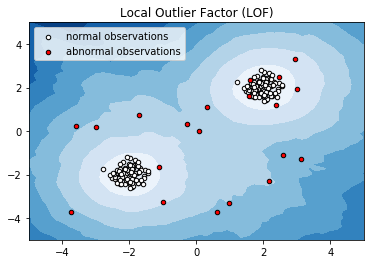

In [26]:
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# generate train data
X = 0.3 *  np.random.randn(100,2)
# generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4,high=4,size=(20,2))
X = np.r_[X+2,X-2,X_outliers]

# fit the model
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
y_pred_outliers = y_pred[200:]

# plot the level sets of the decision function
xx,yy = np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))
Z = clf._decision_function(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)


plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

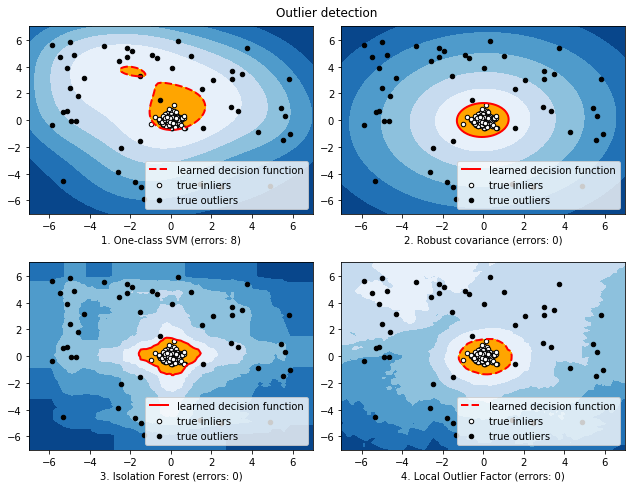

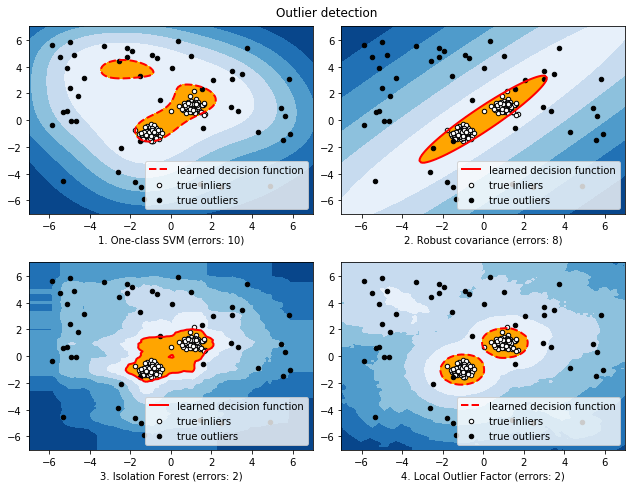

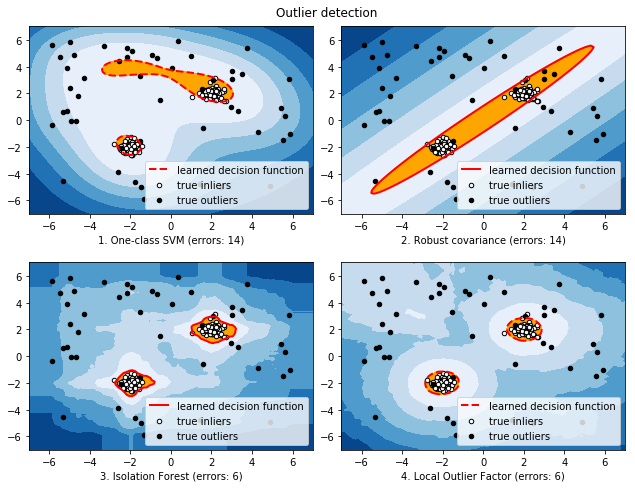

In [29]:
from scipy import stats
import matplotlib.font_manager
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

rng = np.random.RandomState(42)
# example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0,1,2]

# define two outlier detection tools to be compared
classifiers = {
    'One-class SVM':svm.OneClassSVM(nu=0.95*outliers_fraction + 0.05,
                                   kernel='rbf',gamma=0.1),
    'Robust covariance':EllipticEnvelope(contamination=outliers_fraction),
    'Isolation Forest':IsolationForest(max_samples=n_samples,
                                      contamination=outliers_fraction,
                                      random_state=rng),
    'Local Outlier Factor':LocalOutlierFactor(
        n_neighbors=35,contamination=outliers_fraction)
}
# compare given classification under given settings
xx,yy = np.meshgrid(np.linspace(-7,7,100),np.linspace(-7,7,100))
n_inliers = int((1.-outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples,dtype=int)
ground_truth[-n_outliers:] = -1

# fit the problem with varying cluster separation
for i,offset in enumerate(clusters_separation):
    np.random.seed(42)
    # data generation
    X1 = 0.3 *np.random.randn(n_inliers//2,2) - offset
    X2 = 0.3 * np.random.randn(n_inliers//2,2) + offset
    X = np.r_[X1,X2]
    # add outliers
    X = np.r_[X,np.random.uniform(low=-6,high=6,size=(n_outliers,2))]
    
    # fit the model
    plt.figure(figsize=(9,7))
    for i,(clf_name,clf) in enumerate(classifiers.items()):
        if clf_name == 'Local Outlier Factor':
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,100*outliers_fraction)
        
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and points
        if clf_name == 'Local Outlier Factor':
            # decision_function is private for lof
            Z = clf._decision_function(np.c_[xx.ravel(),yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2,2,i+1)
        subplot.contourf(xx,yy,Z,levels=np.linspace(Z.min(),threshold,7),
                        cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

plt.show()
    

Density Estimate

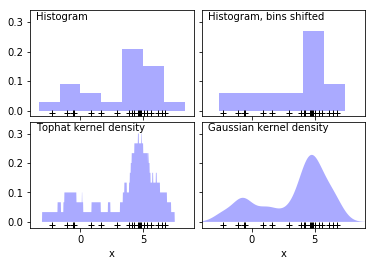

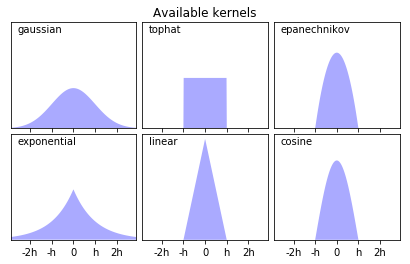

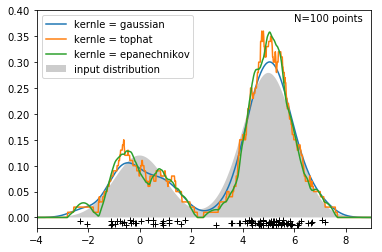

In [4]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# plot the progression of histgrams to kernels
np.random.seed(1)
N = 20
X = np.concatenate((np.random.normal(0,1,int(0.3*N)),
                    np.random.normal(5,1,int(0.7*N))))[:,np.newaxis]
X_plot = np.linspace(-5,10,1000)[:,np.newaxis]
bins = np.linspace(-5,10,10)

fig,ax = plt.subplots(2,2,sharex=True,sharey=True)
fig.subplots_adjust(hspace=0.05,wspace=.05)

# histogram 1
ax[0,0].hist(X[:,0],bins=bins,fc='#AAAAFF',normed=True)
ax[0,0].text(-3.5,0.31,'Histogram')

# histogram 2
ax[0,1].hist(X[:,0],bins=bins+0.75,fc='#AAAAFF',normed=True)
ax[0,1].text(-3.5,0.31,'Histogram, bins shifted')

# tophat KDE
kde = KernelDensity(kernel='tophat',bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1,0].fill(X_plot[:,0],np.exp(log_dens),fc='#AAAAFF')
ax[1,0].text(-3.5,0.31,'Tophat kernel density')

# gaussian Kde
kde = KernelDensity(kernel='gaussian',bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1,1].fill(X_plot[:,0],np.exp(log_dens),fc='#AAAAFF')
ax[1,1].text(-3.5,0.31,'Gaussian kernel density')

for axi in ax.ravel():
    axi.plot(X[:,0],np.zeros(X.shape[0]) - 0.01 ,'+k')
    axi.set_xlim(-4,9)
    axi.set_ylim(-0.02,0.34)
    
for axi in ax[:0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1,:]:
    axi.set_xlabel('x')
    
# _____________________________________
# plot all available kernels
X_plot = np.linspace(-6,6,1000)[:,None]
X_src = np.zeros((1,1))

fig,ax = plt.subplots(2,3,sharex=True,sharey=True)
fig.subplots_adjust(left=0.05,right=0.95,hspace=0.05,wspace=0.05)

def format_func(x,loc):
    if x==0:
        return '0'
    elif x ==1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih'% x

for i,kernel in enumerate(['gaussian','tophat','epanechnikov',
                          'exponential','linear','cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:,0],np.exp(log_dens),'-k',fc='#AAAAFF')
    axi.text(-2.6,0.95,kernel)
    
    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())
    
    axi.set_ylim(0,1.05)
    axi.set_xlim(-2.9,2.9)
ax[0,1].set_title('Available kernels')

#___________________________________________________________________
#plot a 10 density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0,1,int(0.3*N)),
                   np.random.normal(5,1,int(0.7*N))))[:,np.newaxis]
X_plot = np.linspace(-5,10,1000)[:,np.newaxis]

true_dens = (0.3 * norm(0,1).pdf(X_plot[:,0]) + 
            0.7 * norm(5,1).pdf(X_plot[:,0]))

fig,ax = plt.subplots()
ax.fill(X_plot[:,0],true_dens,fc='black',alpha=.2,label='input distribution')

for kernel in ['gaussian','tophat','epanechnikov']:
    kde = KernelDensity(kernel=kernel,bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:,0],np.exp(log_dens),'-',
           label='kernle = {0}'.format(kernel))
ax.text(6,0.38,'N={0} points'.format(N))

ax.legend(loc='upper left')
ax.plot(X[:,0],-0.005 - 0.01 * np.random.random(X.shape[0]),'+k')

ax.set_xlim(-4,9)
ax.set_ylim(-0.02,0.4)
plt.show()
    

In [5]:
X.shape

(100, 1)

In [6]:
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [10]:
from sklearn.datasets import fetch_species_distributions
from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions(data_home='E:/python_work/handson_ml/')
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.

# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = -9999 + np.zeros(land_mask.shape[0])
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c')
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(X, Y, land_reference,
                    levels=[-9999], colors="k",
                    linestyles="solid")
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()

PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'E:/python_work/handson_ml/samples.zip'

Neural network models (unsupervised)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 1.58s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 1.58s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 1.04s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 1.02s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 1.44s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 1.41s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 1.07s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 1.03s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 1.07s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 1.50s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.08, time = 1.00s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.82, time = 1.05s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.64, time = 2.49s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.61, time = 1.06s
[BernoulliRBM] Iteration 15, 

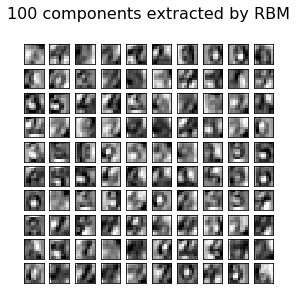

In [7]:
from scipy.ndimage import convolve
from sklearn import linear_model,datasets,metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

# setting up
def nudge_dataset(X,Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8 * 8 images in x around by 1px to letf,right,down,up
    """
    direction_vectors = [
        [[0,1,0],
        [0,0,0],
        [0,0,0]],
        
        [[0,0,0],
        [1,0,0],
        [0,0,0]],
        
        [[0,0,0],
        [0,0,1],
        [0,0,0]],
        
        [[0,0,0],
        [0,0,0],
        [0,1,0]]
        
    ]
    shift = lambda x,w : convolve(x.reshape((8,8)),mode='constant',
                                 weights=w).ravel()
    X = np.concatenate([X]+
                       [np.apply_along_axis(shift,1,X,vector)
                           for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)],axis=0)
    return X,Y
# load data
digits = datasets.load_digits()
X = np.asarray(digits.data,'float32')
X,Y = nudge_dataset(X,digits.target)
X = (X - np.min(X,0)) / (np.max(X,0) + 0.0001) # 0-1 scale
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,
                                                 random_state=0)

# models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0,verbose=True)

classifier = Pipeline(steps=[('rbm',rbm),('logistic',logistic)])

# training
rbm.learning_rate = 0.06
rbm.n_iter = 20
rbm.n_components = 100
logistic.C = 6000.0

classifier.fit(X_train,Y_train)

logistic_classifier = linear_model.LogisticRegression(C = 100)
logistic_classifier.fit(X_train,Y_train)

# evaluation
print('Logistic regression using RBM features:\n%s\n'%(
    metrics.classification_report(
        Y_test,classifier.predict(X_test))))
print('Logistic regression using raw pixel features;\n%s\n'%(
    metrics.classification_report(
        Y_test,logistic_classifier.predict(X_test))))

# plotting
plt.figure(figsize=(4.2,4))
for i,comp in enumerate(rbm.components_):
    plt.subplot(10,10,i+1)
    plt.imshow(comp.reshape((8,8)),cmap=plt.cm.gray_r,
              interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM',fontsize=16)
plt.subplots_adjust(0.08,0.02,0.92,0.85,0.05,0.23)

plt.show()
